# MovieLens 1M dataset

There are 3 datasets which contains more than 1 million(1,000,209) ratings from approximately 6 thousands (6,040) users for about 3,900 different movies. And those users started to use MovieLens in 2020.

# 0.Packages we used in the project

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import Image, display
import numpy as np

import requests
!pip cache purge
!pip install html5lib

from bs4 import BeautifulSoup
import plotly.express as px
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#Reference: https://plotly.com/python/choropleth-maps/
#Reference: https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html
#Reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html#pandas.DataFrame.explode

Files removed: 0

In [4]:
train_test_split

<function sklearn.model_selection._split.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)>

# 1.Intro to dataset & manipulating

In this project, we hope to explore the immense quantity of information in the MovieLens datasets, which includes 1,000,209 anonymous movie ratings from 6,040 people. Finding complex patterns and insights in these evaluations is the main objective of this investigation, which focuses on how various demographic groups view and rank films in a wide range of genres on either the count(the number of ratings) for each movie genre, or the average rating. This dataset provides a rare chance to comprehend the dynamics of movie ratings and preferences among various audience categories. It is a treasure trove of user preferences and behaviours.

The rich, multifaceted data from the MovieLens project, run by the University of Minnesota's GroupLens Research Group, served as the basis for this analysis. In addition to ratings, the dataset gives extensive details on the movies themselves, including genre, title, and year of release, as well as relevant demographic data about the users, such as age, gender, occupation, and location. An in-depth investigation of user preferences and behaviours is made possible by these data layers.

This analysis's methodology makes use of advanced data analytics methods. Advanced visualization techniques, content-based filtering, collaborative filtering, and other techniques will be employed to decipher the intricate links that exist between users and movies. The objective is to investigate how user preferences differ among various demographic groups and cinema genres, in addition to understanding what influences these preferences.

The output will include the trends and patterns in movie ratings across different demographics and genres. This will include heatmaps, bar charts, and other forms of data visualization to make the data accessible and understandable. Through this analysis, we aim to provide a deeper, more nuanced understanding of movie preferences and ratings for different groups of people, which could be helpful for further machine learning research, as well as the recommendation system.

In movies.dat, there are 3 columns, the encoded movie's ID, the title of the movie, the genres of the movie.

Firstly, we need to covert the .dat dataset into .csv.

In [5]:
file_path = 'movies.dat'

with open(file_path, 'r', encoding='latin1') as file:
    data = file.readlines()

def extract_year(movie_title):
    match = re.search(r'\((\d{4})\)', movie_title)
    if match:
        return match.group(1), re.sub(r'\(\d{4}\)', '', movie_title).strip()
    else:
        return None, movie_title

def split_line(line):
    parts = line.strip().split("::")
    if len(parts) == 3:
        year, title = extract_year(parts[1])
        categories = parts[2].split("|")
        return [parts[0], title] + [year] + categories

processed_data = [split_line(line) for line in data]

df = pd.DataFrame(processed_data)

csv_file_path = 'movies.csv'
df.to_csv(csv_file_path, index=False, header=False)

In [6]:
file_88 = 'movies.csv'
movies = pd.read_csv(file_88)
print(movies.head())

   1                    Toy Story  1995  Animation  Children's    Comedy  \
0  2                      Jumanji  1995  Adventure  Children's   Fantasy   
1  3             Grumpier Old Men  1995     Comedy     Romance       NaN   
2  4            Waiting to Exhale  1995     Comedy       Drama       NaN   
3  5  Father of the Bride Part II  1995     Comedy         NaN       NaN   
4  6                         Heat  1995     Action       Crime  Thriller   

  Unnamed: 6 Unnamed: 7 Unnamed: 8  
0        NaN        NaN        NaN  
1        NaN        NaN        NaN  
2        NaN        NaN        NaN  
3        NaN        NaN        NaN  
4        NaN        NaN        NaN  


In users.dat, there are 5 columns, and they are respectively the user's ID, and the user's gender(F/M), age, occupation and zip-code.

In [7]:
file_path = 'users.dat'

with open(file_path, 'r', encoding='latin1') as file:
    data = file.readlines()

def split_line(line):
    parts = line.strip().split("::")
    return parts

processed_data = [split_line(line) for line in data]

df = pd.DataFrame(processed_data)

csv_users = 'users.csv'
df.to_csv(csv_users, index=False, header=False)

In [8]:
file_2 = 'users.csv'
users = pd.read_csv(file_2)
print(users.head())

   1  F  1.1  10  48067
0  2  M   56  16  70072
1  3  M   25  15  55117
2  4  M   45   7  02460
3  5  M   25  20  55455
4  6  F   50   9  55117


In ratings.dat, there are 4 columns, the first one is the user ID encoded from 1 to 6,040, note that every user has already rated more than 20 movies. The second column shows the code which can represent the 3,952 movies which they rated. As well as the rated score from 1 to 5 in the third column. The last column shows the Timestamp in second.

In [9]:
file_path = 'ratings.dat'

with open(file_path, 'r', encoding='latin1') as file:
    data = file.readlines()

def split_line(line):
    parts = line.strip().split("::")
    return parts

processed_data = [split_line(line) for line in data]
df = pd.DataFrame(processed_data)

csv_ratings = 'ratings.csv'
df.to_csv(csv_ratings, index=False, header=None)
file_3 = 'ratings.csv'
ratings = pd.read_csv(file_3)
print(ratings.head())
ratings.shape

   1  1193  5  978300760
0  1   661  3  978302109
1  1   914  3  978301968
2  1  3408  4  978300275
3  1  2355  5  978824291
4  1  1197  3  978302268


(1000208, 4)

Create a csv file which does not split the types of the movie for which has more than one genre(for latter use for creating the heat map of ratings and occupations).

In [10]:
###Split the data without split movie which has more than one types
file_path = 'movies.dat'

with open(file_path, 'r', encoding='latin1') as file:
    data = file.readlines()

def extract_year(movie_title):
    match = re.search(r'\((\d{4})\)', movie_title)
    if match:
        return match.group(1), re.sub(r'\(\d{4}\)', '', movie_title).strip()
    else:
        return None, movie_title

def split_line(line):
    parts = line.strip().split("::")
    if len(parts) == 3:
        year, title = extract_year(parts[1])
        categories = parts[2]
        return [parts[0], title, year, categories]
    else:
        return parts

processed_data = [split_line(line) for line in data]

df = pd.DataFrame(processed_data)

csv_file_path = 'movies2.csv'
df.to_csv(csv_file_path, index=False, header=False)

# 2.Research Question

The data contains users' information (age, occupation, gender) as well as data about the movie itself (year of release, genre) and the movie ratings. In this report, we analyse these factors and explore the relationship between each of them and movie ratings. Finally, we will explore the relationship between these factors and movie ratings in two aspects:
1.   Users' data
2.   Movie itself (especially the genre of movie)

Separately, building appropriate models and making predictions to investigate which attribute of user data or the movie itself can be better used to predict the movie scores and find the best model.

# 3.Merge dataset

To make life easier, we can start with merging these 3 important datasets.

In [11]:
## We can merge these 3 datasets together by using merges into a single main.csv
users = pd.read_csv(file_2, header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode'])
movies_tomerge = pd.read_csv('movies.csv', header=None, names=['MovieID', 'Title', 'Year', 'Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6'])
ratings_tomerge = pd.read_csv('ratings.csv', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

user_r = pd.merge(users, ratings_tomerge)
main = pd.merge(user_r, movies_tomerge)
main.head()
print(main.shape)

(1000209, 16)


In [ ]:
main.to_csv('main.csv', index=False)

In [13]:
main.head()

,UserID,Gender,Age,Occupation,ZipCode,MovieID,Rating,Timestamp,Title,Year,Genre1,Genre2,Genre3,Genre4,Genre5,Genre6
0,1,F,1,10,48067,1193,5,978300760,One Flew Over the Cuckoo's Nest,1975,Drama,NaN,NaN,NaN,NaN,NaN
1,2,M,56,16,70072,1193,5,978298413,One Flew Over the Cuckoo's Nest,1975,Drama,NaN,NaN,NaN,NaN,NaN
2,12,M,25,12,32793,1193,4,978220179,One Flew Over the Cuckoo's Nest,1975,Drama,NaN,NaN,NaN,NaN,NaN
3,15,M,25,7,22903,1193,4,978199279,One Flew Over the Cuckoo's Nest,1975,Drama,NaN,NaN,NaN,NaN,NaN
4,17,M,50,1,95350,1193,5,978158471,One Flew Over the Cuckoo's Nest,1975,Drama,NaN,NaN,NaN,NaN,NaN


# 4.Evolutionary of Film Industry over Time

We want to explore whether people tend to give a higher rating for old movies or not. This can raise a discussion: Someone claims that vintage/old movies might be considered 'classics', and thus may receive higher ratings due to their historical significance or romantic appeal. On the other hand, it is also possible that older movies might not resonate as well with modern audiences due to changes in societal norms, filmmaking technology, and storytelling styles. This can lead to lower ratings compared to modern recent movies.

We will make the visualization and analysis below to discover whether older movies are more popular than the modern ones. This analysis may be helpful for filmmakers, critics, and streaming services to develop a more detailed insight of the movies evolutionary over time, as well as the audience preference.

In [17]:
#Extract the "Year" and "Rating" columns to form a new dataframe called year_rating.
year_rating = main[["Year","Rating"]]
#Sort data by year in ascending order.
year_rating = year_rating.sort_values("Year")
#print(year_rating)

#Print the list of the ratings for each year from 1919 to 2020(only showing the first 5 ratings in the first 5 years here).
grouped_df = year_rating.groupby('Year')
year_dfs = [group for _, group in grouped_df]
for i, year_df in enumerate(year_dfs):
    print(f"Year {year_df['Year'].iloc[0]}:")
    print(year_df.head())
    print("\n")
    if i == 4:
        break

Year 1919:
        Year  Rating
956147  1919       3
956128  1919       3
956129  1919       5
956130  1919       4
956131  1919       4


Year 1920:
        Year  Rating
507293  1920       5
507294  1920       4
507276  1920       3
507296  1920       3
507292  1920       5


Year 1921:
        Year  Rating
990983  1921       4
991003  1921       5
991002  1921       4
991001  1921       5
991000  1921       4


Year 1922:
        Year  Rating
819518  1922       4
819517  1922       4
819516  1922       4
819515  1922       2
819514  1922       4


Year 1923:
        Year  Rating
996760  1923       4
996764  1923       5
996763  1923       1
996762  1923       5
996761  1923       1


In [ ]:
#Calculate the average rating for each year.
grouped_ratings = year_rating.groupby('Year')['Rating'].mean()
print("Average Ratings:")
print(grouped_ratings)
print("Highest rating is:")
print(round(max(grouped_ratings),3))
print("Lowest rating is:")
print(round(min(grouped_ratings),3))

Average Ratings:
Year
1919    3.466667
1920    3.666667
1921    3.790323
1922    3.991597
1923    3.117647
          ...   
1996    3.388502
1997    3.411654
1998    3.457729
1999    3.496459
2000    3.373341
Name: Rating, Length: 81, dtype: float64
Highest rating is:
4.278
Lowest rating is:
3.118


By calculating the avergae rating for each year, we find that the highest is 4.278 and the lowest is 3.118.

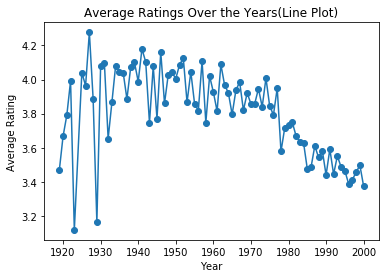

In [ ]:
#Plot a line plot of Average Ratings Over the Years.
plt.plot(grouped_ratings.index, grouped_ratings.values, marker='o', linestyle='-')
plt.title('Average Ratings Over the Years(Line Plot)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

Then to visualise the distribution, we plot a line plot and obtain that the highest rating is in 1927 and the lowest rating is in 1923.

Without consideration of selection bias, from the line plot we can see that,the rating is oscillating considerably over early period especially from 1920 to 1930, but the peak rating appeares during this period. This might indicate a sincere admiration for some films. The big oscillation might indicate the survivorship bias, which might lead to the high score movies gain higher rating, low score movies gain lower rating, there are a small number of movies are well-known and tagged as 'classic', while another movie which are not that sophisticated gains a lower rating. Or, they gained low scores because of the comparison to those 'classic' movie. However, the uncertainty in the average ratings of older movies is also likely due to fewer ratings for each movie.

Before the 21st century, the average ratings continue to fall slightly, although they appear to stabilise in the late 1990s. This might point to a leveling off of user rating behaviour as the number of reviewed movies rises.

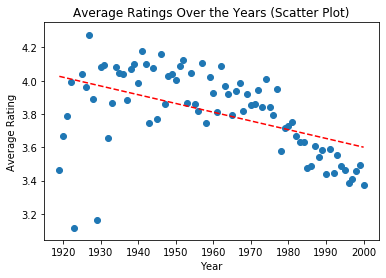

In [ ]:
#Plot a scatter plot of Average Ratings Over the Years.
x = grouped_ratings.index
y = grouped_ratings.values
plt.scatter(x, y, marker='o')
plt.title('Average Ratings Over the Years (Scatter Plot)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

From the Scatter plot, the trend is more obvious over time. The ratings show a decreasing trend since the 1940s all the way to 2000.

The average ratings clearly show a declining trend beginning in the late 1970s. This trend may indicate that consumers generally give lower ratings to more recent films, maybe as a result of higher standards and more critical attention.

In [ ]:
#Calculate the number of ratings per genre for each year, record that data as "Count".
all_genres = pd.DataFrame()
genre_columns = ['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6']

for genre_col in genre_columns:
    temp = main[['Year', genre_col]].rename(columns={genre_col: 'Genre'})
    all_genres = pd.concat([all_genres, temp])

all_genres.dropna(subset=['Genre'], inplace=True)

genre_counts = all_genres.groupby(['Year', 'Genre']).size().reset_index(name='Count')

print(genre_counts)

     Year      Genre  Count
0    1919     Action      4
1    1919  Adventure      3
2    1919     Comedy     38
3    1919      Drama      7
4    1920     Comedy     24
..    ...        ...    ...
893  2000    Mystery    577
894  2000    Romance   2136
895  2000     Sci-Fi   5605
896  2000   Thriller  10086
897  2000        War   1309

[898 rows x 3 columns]


Next, to further explore the data, the number of ratings per genre every year are recorded as "Count". For instance, in 2000, 5605 ratings are made for Sci-Fi movies and 10086 ratings are made for Thriller movies.

In [ ]:
#Use unique() to get unique values from the 'Genre' column and then conver the result to a list.
unique_genres = all_genres['Genre'].unique().tolist()
#Create a new DataFrame from the list.
unique_genres = pd.DataFrame(unique_genres, columns=['Genre'])
print(unique_genres)

          Genre
0         Drama
1     Animation
2       Musical
3        Action
4        Comedy
5     Adventure
6       Romance
7    Children's
8      Thriller
9         Crime
10      Western
11  Documentary
12      Mystery
13       Horror
14       Sci-Fi
15    Film-Noir
16          War
17      Fantasy


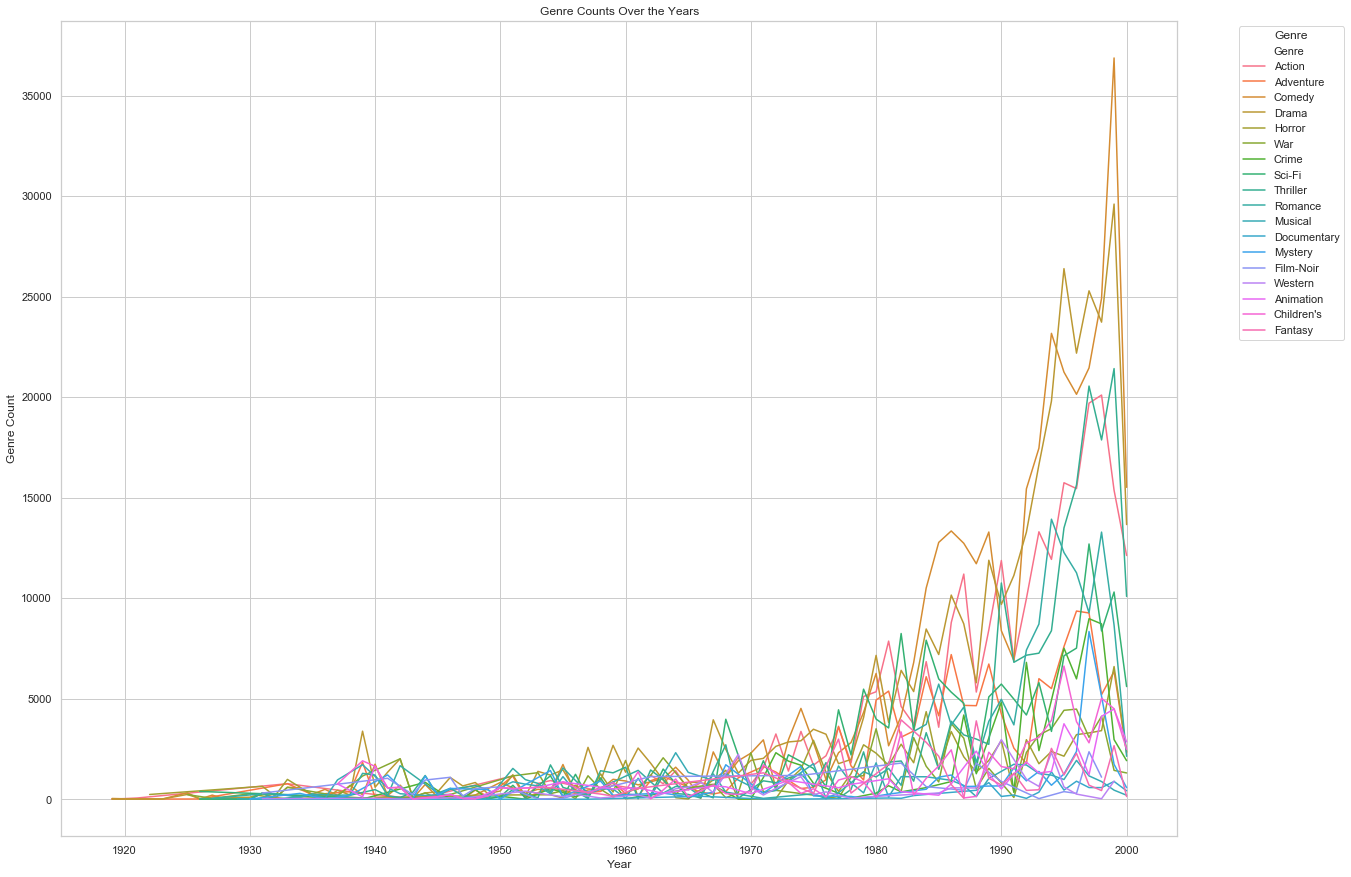

In [ ]:
#Plot a plot of Genre Counts Over the Years.
sns.set(style="whitegrid")
plt.figure(figsize=(20, 15))
sns.lineplot(x='Year', y='Count', hue='Genre', data=genre_counts)
plt.xlabel('Year')
plt.ylabel('Genre Count')
plt.title('Genre Counts Over the Years')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

From the overall trend, we can see that there is an increasing engagement over time, and engagement reaches the peak around the late 1990s and early 2000s which indicating that modern movies have more audiences(generally speaking, the more the ratings, the more the people watching).

There are some interesting things to notice: Firstly, drama and comedy appear to be the most often rated genres. We can see that ratings for Comedy reaches the all time highest in the late 1990s with a number above 35000, and the second highest is Drama in the same year(slightly below 30000). Secondly, a first small peak is observed around 1937, there might be some “the classical Hollywood” be published since Hollywood was at its most prosperous, golden age period, between 1927-1945. Also, some social factors might also affect the film industry, such as World War II, economic crisis in US, providing a wide range of themes for Crime movie, War movie as well as film Noir. This might make those movies published in 1940s be considered academically valuable. Finally, Sci-Fi movies become popular since 1990s, this might because of technological advancements in filmmaking.

In [ ]:
#Calculate the total counts for each year
total_counts_per_year = genre_counts.groupby('Year')['Count'].sum().reset_index(name='Total_Count')
print(total_counts_per_year)

    Year  Total_Count
0   1919           52
1   1920           24
2   1921           62
3   1922          238
4   1923           17
..   ...          ...
76  1996       129816
77  1997       150755
78  1998       147028
79  1999       155212
80  2000        73706

[81 rows x 2 columns]


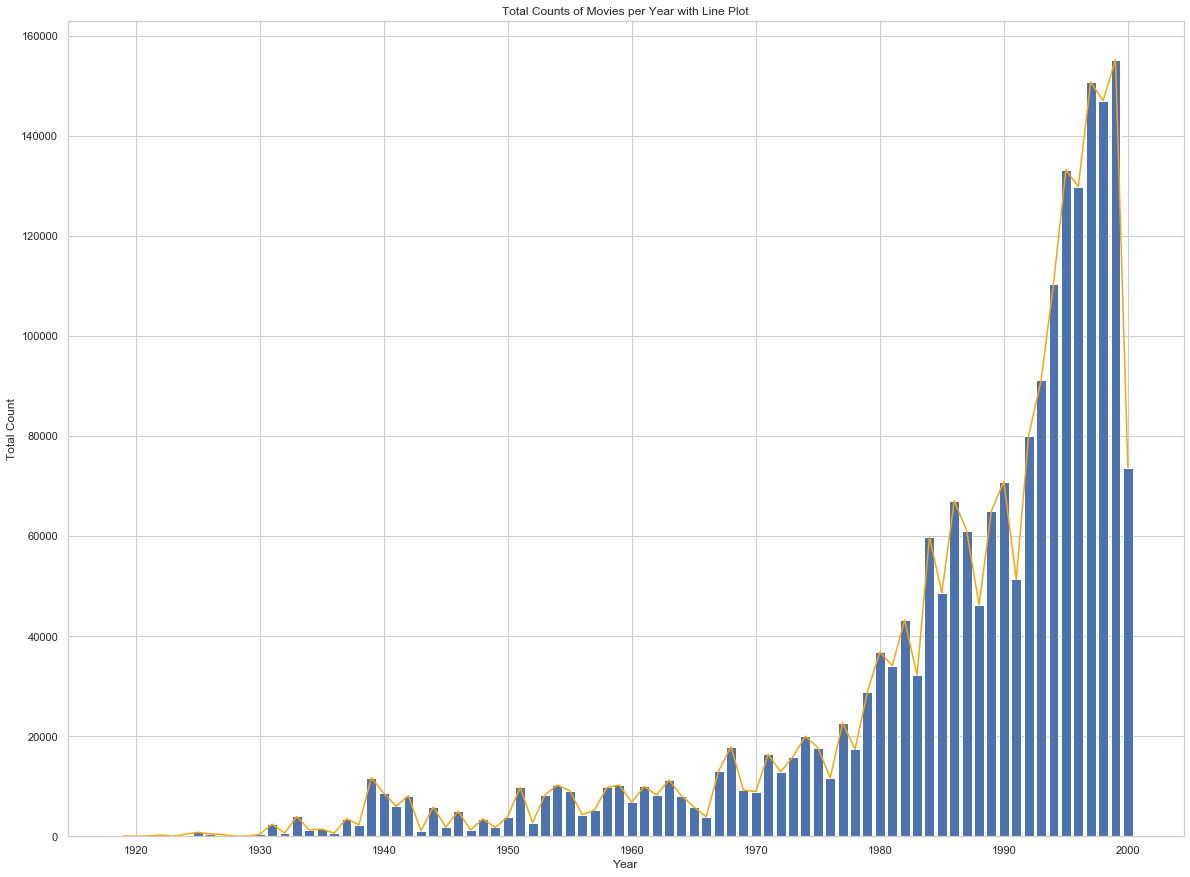

In [ ]:
plt.figure(figsize=(20, 15))
plt.bar(total_counts_per_year.Year, total_counts_per_year.Total_Count)
plt.plot(total_counts_per_year['Year'], total_counts_per_year['Total_Count'], color='orange')
plt.xlabel('Year')
plt.ylabel('Total Count')
plt.title('Total Counts of Movies per Year with Line Plot')
plt.show()

We sum the total counts for each year, and plot a bar chart to visualise the data. It can be seen that there is an obvious increasing trend in the number of ratings. Count soars since the 1980s and reach the peak in 1999 with 155212 ratings. Clearly showing us that people are more likely to choose modern movies to watch in their daily life.

# 5.Analysis for Users

In [ ]:
ratings_tomerge.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [18]:
#Count the number of ratings each user made, there are 6040 users overall. Select the top 5.
ratings_tomerge['UserID'].value_counts().head()

4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
Name: UserID, dtype: int64

Here, we analyse the ratings data by counting the number of ratings each user made, and then sort the list in a descending order. We select and display the top 5 users who made the most reviews. From above, we can see that user with id 4169 made 2314 ratings, which is the highest number among all.

Some bar charts, histograms and boxplot are used to visualise the distribution of number of ratings per user.

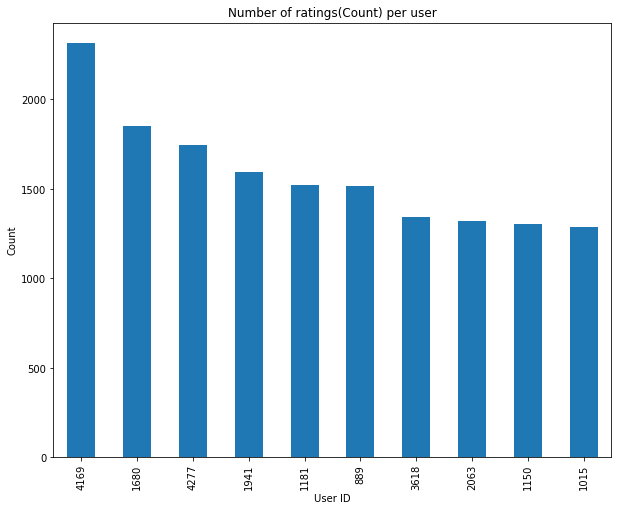

In [22]:
ratings_tomerge['UserID'].value_counts().head(10).plot(kind='bar')
plt.title('Number of ratings(Count) per user')
plt.xlabel('User ID')
plt.ylabel('Count')
plt.show()

A bar chart is used to visualise the result we get, user id 4169 is the top rater.

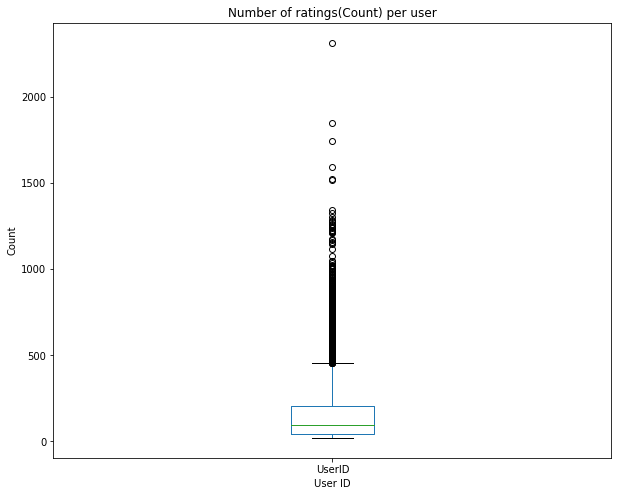

In [24]:
ratings_tomerge['UserID'].value_counts().plot(kind='box')
plt.title('Number of ratings(Count) per user')
plt.xlabel('User ID')
plt.ylabel('Count')
plt.show()

The boxplot shows that the median is around 100. The users who made more than 500 ratings are treated as outliers(extreme values). The 25th and 75th quantiles are roughly 50 and 250 respectively.



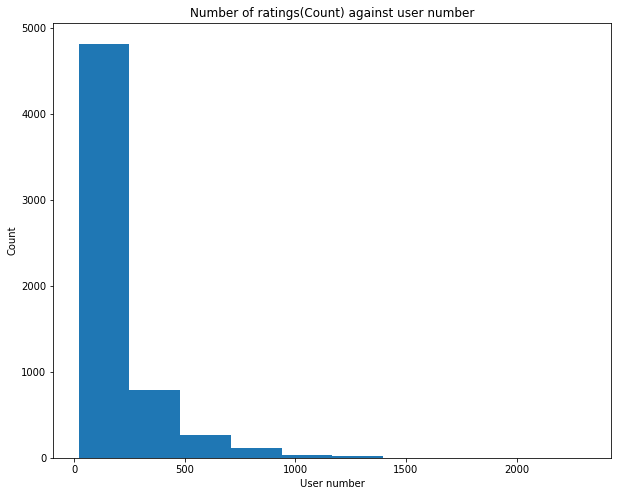

In [25]:
ratings_tomerge['UserID'].value_counts().plot(kind='hist')
plt.title('Number of ratings(Count) against user number')
plt.xlabel('User number')
plt.ylabel('Count')
plt.show()

The histogram shows that around 4900 users made 1-250 ratings, which is the largest proportion. Roughly 900 users made 250-480 ratings, 200 users made 480-700 ratings, 100 users made 700-900 ratings and the number of users who made more than 900 ratings are negligible.

# 6.Movie Analysis

In [19]:
ratings_tomerge['MovieID'].value_counts().head()

2858    3428
260     2991
1196    2990
1210    2883
480     2672
Name: MovieID, dtype: int64

Then, we analayse the ratings data by evaluating the films rated. From above, we can see that movie id 2858 has the most number of ratings(3428). We select and display the top movies that has the highest number of ratings.

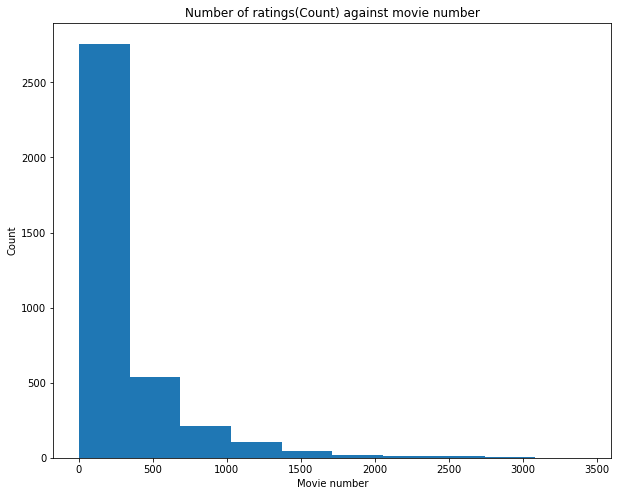

In [26]:
ratings_tomerge['MovieID'].value_counts().plot(kind='hist')
plt.title('Number of ratings(Count) against movie number')
plt.xlabel('Movie number')
plt.ylabel('Count')
plt.show()

Similarly, the histogram shows that around 2800 movies has 0-300 ratings, which is the largest proportion. Roughly 510 movies has 300-700 ratingss, 200 users made 700-1050 ratings, and the rest(a small number) of films has more than 1050 ratings made to them.

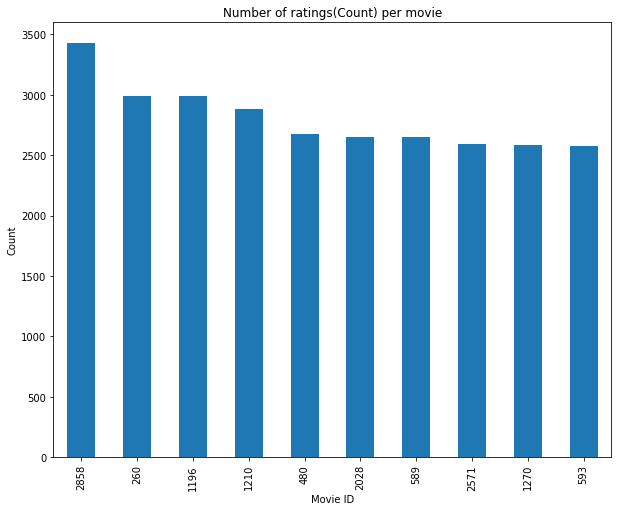

In [27]:
ratings_tomerge['MovieID'].value_counts().head(10).plot(kind='bar')
plt.title('Number of ratings(Count) per movie')
plt.xlabel('Movie ID')
plt.ylabel('Count')
plt.show()

A bar chart is used to visualise the result we get, movie id 2858 has the most ratings.

In [ ]:
movies_tomerge.head()

,MovieID,Title,Year,Genre1,Genre2,Genre3,Genre4,Genre5,Genre6
0,1,Toy Story,1995,Animation,Children's,Comedy,NaN,NaN,NaN
1,2,Jumanji,1995,Adventure,Children's,Fantasy,NaN,NaN,NaN
2,3,Grumpier Old Men,1995,Comedy,Romance,NaN,NaN,NaN,NaN
3,4,Waiting to Exhale,1995,Comedy,Drama,NaN,NaN,NaN,NaN
4,5,Father of the Bride Part II,1995,Comedy,NaN,NaN,NaN,NaN,NaN


In [ ]:
movies_tomerge['MovieID'].nunique()

3883

In [ ]:
movies_tomerge['Year'].nunique()

81

There are 3883 films in the dataset across 81 years from 1919-2000.

In [ ]:
#Select the 'year' and 'movie_id' columns from the 'movies' DataFrame, then group the data by the 'year' column.
#And use count() to count the number of occurrences for each year. The result is stored in a new dataframe called
#number_of_movies_per_year
number_of_movies_per_year = movies_tomerge[['Year', 'MovieID']].groupby(['Year']).count().reset_index()
number_of_movies_per_year.columns = ['Year', 'Number of Movies']
print(number_of_movies_per_year)

    Year  Number of Movies
0   1919                 3
1   1920                 2
2   1921                 1
3   1922                 2
4   1923                 3
..   ...               ...
76  1996               345
77  1997               315
78  1998               337
79  1999               283
80  2000               156

[81 rows x 2 columns]


We are now counting the number of movies per year. The result shows that, for example, there are 3 movies published in 1919, 345 movies in 1996 and 156 in 2000.

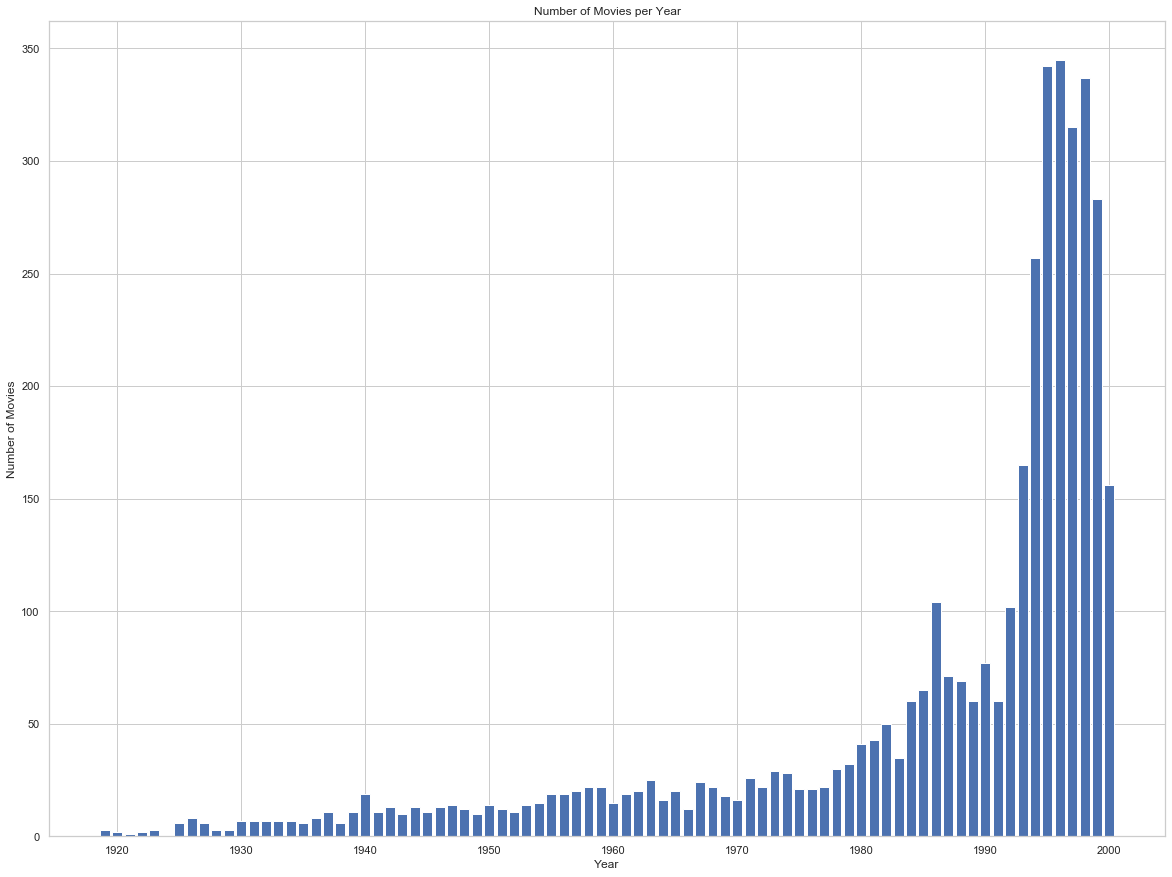

In [ ]:
plt.figure(figsize=(20, 15))
plt.bar(number_of_movies_per_year['Year'], number_of_movies_per_year['Number of Movies'])
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies per Year')
plt.show()

From the bar chart, we can see that most of the movies in the dataset are published during 1990-2000, only few(less than 50) are released each year before 1983. Further showing a boom in the movie industry during that time.

In [ ]:
# Reshape the DataFrame to have one row per genre for each movie
movies_expanded = movies_tomerge.melt(id_vars=['Year', 'MovieID'], value_vars=['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6'], var_name='Genre', value_name='Genre_Value')
# Drop rows with NaN values in 'Genre_Value'
movies_expanded = movies_expanded.dropna(subset=['Genre_Value'])
# Combine genre columns into a single column 'Genre'
movies_expanded['Genre'] = movies_expanded['Genre_Value']
# Group by 'year' and 'Genre' and count the number of movies
movies_per_genre_per_year = movies_expanded.groupby(['Year', 'Genre']).size().reset_index(name='Number of Movies')

#print(movies_expanded)
print(movies_per_genre_per_year)

     Year      Genre  Number of Movies
0    1919     Action                 1
1    1919  Adventure                 1
2    1919     Comedy                 1
3    1919      Drama                 2
4    1920     Comedy                 2
..    ...        ...               ...
899  2000    Mystery                 1
900  2000    Romance                17
901  2000     Sci-Fi                10
902  2000   Thriller                25
903  2000        War                 2

[904 rows x 3 columns]


We aim to evaluate the trend of movies of different genres over the years. For example, 17 romance movies are released in 2000.

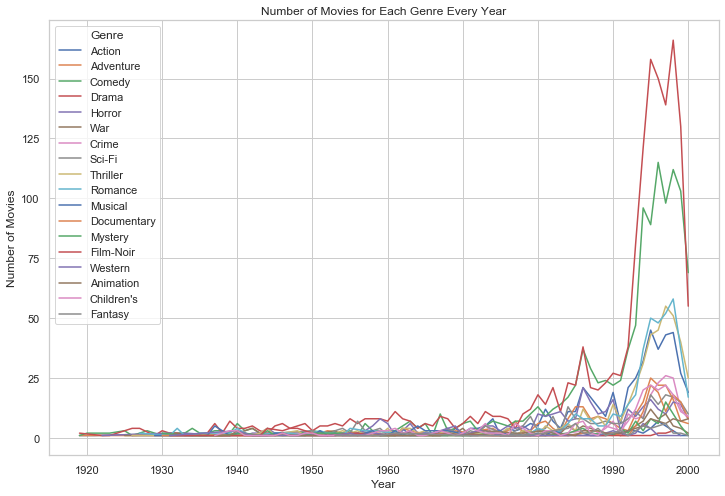

In [ ]:
# Plot the Number of Movies for Each Genre Every Year
plt.figure(figsize=(12, 8))
for genre in movies_per_genre_per_year['Genre'].unique():
    genre_data = movies_per_genre_per_year[movies_per_genre_per_year['Genre'] == genre]
    plt.plot(genre_data['Year'], genre_data['Number of Movies'], label=genre)

plt.title('Number of Movies for Each Genre Every Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.legend(title='Genre')
plt.show()

From this plot, we can see that Film-Noir and comdy movies experience a grear surge in numbers starting in the early 1990s and reached their peak in aorund 1997. All the other genres also have a similar trend but not as significant.

We can discover a very close analysis to Genre Counts Over the Years from above.

In [ ]:
# Reshape the DataFrame to have one row per genre for each movie
movies_1 = main.melt(id_vars=['Rating', 'MovieID'], value_vars=['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6'], var_name='Genre', value_name='Genre_Value')
# Drop rows with NaN values in 'Genre_Value'
movies_1 = movies_1.dropna(subset=['Genre_Value'])
# Combine genre columns into a single column 'Genre'
movies_1['Genre'] = movies_1['Genre_Value']
movies_1

,Rating,MovieID,Genre,Genre_Value
0,5,1193,Drama,Drama
1,5,1193,Drama,Drama
2,4,1193,Drama,Drama
3,4,1193,Drama,Drama
4,5,1193,Drama,Drama
...,...,...,...,...
5726661,4,1205,War,War
5726662,1,1205,War,War
5726663,1,1205,War,War
5726664,3,1205,War,War


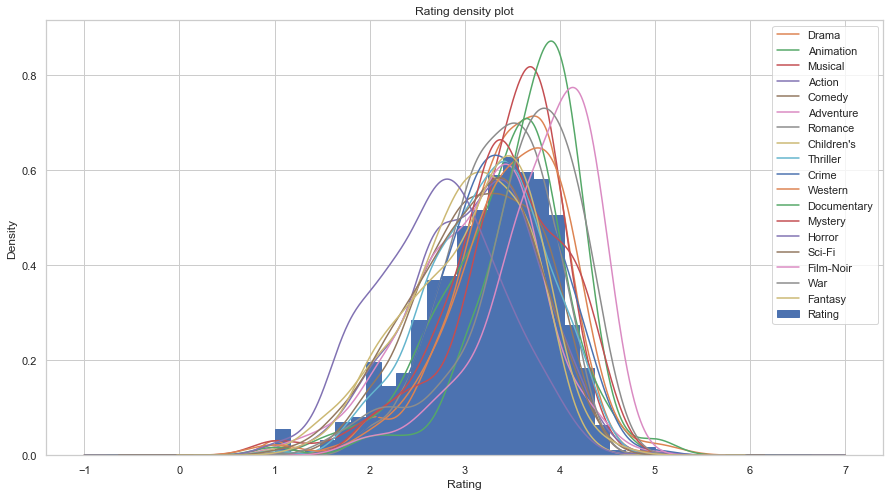

In [ ]:
df = main[['MovieID','Rating']].groupby('MovieID').mean()
df.plot(kind='hist',bins=25, grid=False, edgecolor='b', density=True, figsize=(15,8), title='Rating density plot')

for genre in movies_1['Genre'].unique():
    df_temp = movies_1[movies_1['Genre']==genre][['MovieID','Rating']].groupby('MovieID').mean()
    df_temp.Rating.plot(grid=True, kind='kde', label=genre)
plt.legend()
plt.xlabel('Rating')
plt.show()

The rating density plot for each genre shows that the distribution for most of the genres are left-skewed with a mean in the range of 3-4. But this is not the case for horror type as its rating is lower than the others.

The horror genre is notable for having a lower mean rating compared with others. Its peak density is pushed to the left, suggesting that consumers give horror films lower ratings overall. For certain genres, such as Film-Noir and Documentary, exhibit a more distinct peak, indicating a more uniform rating trend within those categories.

# 7.Gender Preferences

We assume that different gender populations might have different preferences for movie.
For example, someone might assume that most female prefer to watch drama than adventure movie, and more male watching action movies, rather than romance according to stereotypes.

Note that here we choose to plot the bar chart using the count of audience for each movie genre for male and female, but not average rating. Because some genre, like documentary, always have a consistently great quality, which can skew average ratings. They might attract a small group of dedicated audience who will always rate this kind of movie a high rating. And this group of people is very likely to contain female and male evenly, this might lead to our result be biased. Hence, focusing on audience count rather than average rating provides a clearer picture of overall popularity and viewer preference across genres without the influence of potentially skewed ratings.

We can obtain the data of popularity of a movie genre is by plotting a bar chart.

In [15]:
gender_counts = main.groupby('Gender').size()
print(gender_counts)
# The ratio of female and male is 1:3

Gender
F    246440
M    753769
dtype: int64


It is clear that the number of male users is much higher than the number of female users. When we do the visualization of the gender preference, it would be clearer and more sensible if we normalize he number of female and male, making the comparison fair.

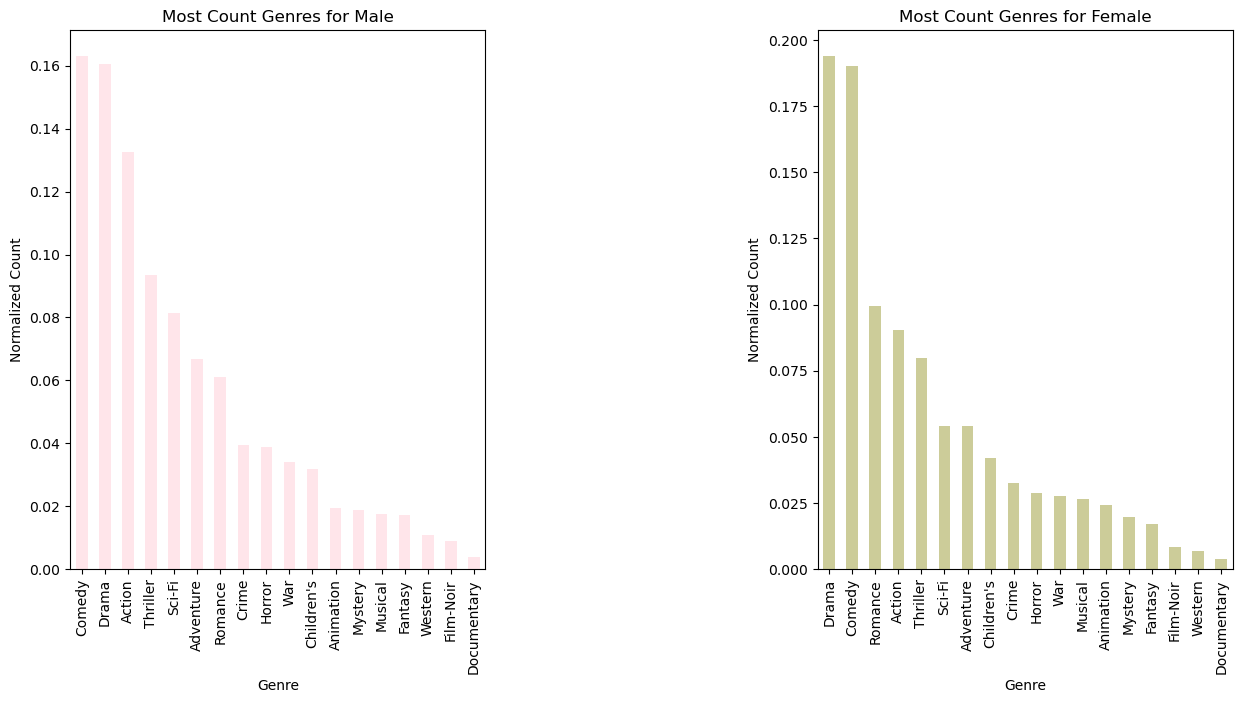

In [ ]:
#Calculate the number of ratings per genre for both female and male, and normalize the number of count.
all_genres = pd.DataFrame()
genre_columns = ['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6']

for genre_col in genre_columns:
    temp = main[['Gender', genre_col]].rename(columns={genre_col: 'Genre'})
    all_genres = pd.concat([all_genres, temp])

all_genres.dropna(subset=['Genre'], inplace=True)

genre_counts = all_genres.groupby(['Gender', 'Genre']).size().reset_index(name='Count')
genre_counts['NormalizedCount'] = genre_counts.groupby('Gender')['Count'].transform(lambda x: x / x.sum())

pivot_table = genre_counts.pivot(index='Genre', columns='Gender', values='NormalizedCount').fillna(0)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))

pivot_table['M'].sort_values(ascending=False).head(20).plot(kind="bar", color="pink", alpha=0.4, ax=axes[0])
axes[0].set_title('Most Count Genres for Male')
axes[0].set_ylabel('Normalized Count')

pivot_table['F'].sort_values(ascending=False).head(20).plot(kind="bar", color="olive", alpha=0.4, ax=axes[1])
axes[1].set_title('Most Count Genres for Female')
axes[1].set_ylabel('Normalized Count')

fig.subplots_adjust(wspace=0.8)
plt.show()

From above 2 bar charts, we obtain that the top 3 popular movie genres for male are Comedy, Drama and Action. Comedy would be the most preferred. And the top 3 popular movie genres for female are Drama, Comedy and Romance. It is clear that Drama and Comedy stand out with a notably higher normalized count compared to others.

Both genders watch Drama and Comedy the most, indicating that they are more attractive for them. And least users for both gender watch Documentary, Western and Film-Noir.

We can also see from both the differences of the trends, and the normalized scales, Male users population has a slightly wider preference spread across all the different genres, after the top three genres. Female users' preference is relatively more concentrated on the top 2 popular movie genres.

From above, we can see that the preferences of female and male are quite similar, but there are still some difference. For example, if we rank the counts of ratings for all movie genres, rank of male's count for Romance movie is 7th, but the female's rank is 3rd. Also, the big difference is also obvious in Animation movie: 8th for female and 11th for male. We can plot a violin plot to see the rating's distribution in both female and male.

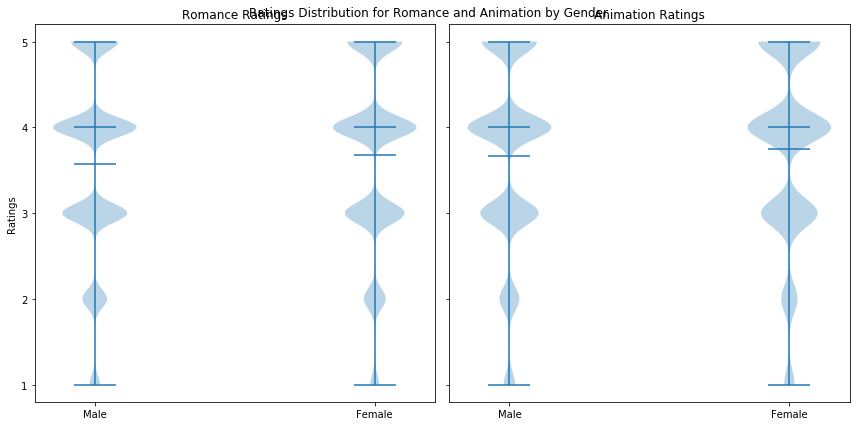

In [ ]:
# Discover all ratings for Romance and Animation
d_ratings = main[(main['Genre1'] == 'Romance') |
                     (main['Genre2'] == 'Romance') |
                     (main['Genre3'] == 'Romance') |
                     (main['Genre4'] == 'Romance') |
                     (main['Genre5'] == 'Romance') |
                     (main['Genre6'] == 'Romance')]

c_ratings = main[(main['Genre1'] == 'Animation') |
                      (main['Genre2'] == 'Animation') |
                      (main['Genre3'] == 'Animation') |
                      (main['Genre4'] == 'Animation') |
                      (main['Genre5'] == 'Animation') |
                      (main['Genre6'] == 'Animation')]

# Split them into male and female
male_d = d_ratings[d_ratings['Gender'] == 'M']['Rating'].tolist()
female_d = d_ratings[d_ratings['Gender'] == 'F']['Rating'].tolist()

male_c = c_ratings[c_ratings['Gender'] == 'M']['Rating'].tolist()
female_c = c_ratings[c_ratings['Gender'] == 'F']['Rating'].tolist()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

axes[0].violinplot([male_d, female_d], points=100, widths=0.3, showmedians=True, showmeans=True)
axes[0].set_title('Romance Ratings')
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(['Male', 'Female'])
axes[0].set_ylabel('Ratings')

axes[1].violinplot([male_c, female_c], points=100, widths=0.3, showmedians=True, showmeans=True)
axes[1].set_title('Animation Ratings')
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['Male', 'Female'])

plt.yticks(range(1, 6))
plt.suptitle('Ratings Distribution for Romance and Animation by Gender')
plt.tight_layout()
plt.show()


We can see that there are more higher female ratings for Animation and Romance than male, and widths of female violin graphs are narrower in score 2 and 1 for these 2 movie genres compared to male's. Indicating that there are less female rating 1 and 2 for Romance and Animation. However, for these 2 movie genres, ratings from population have similar pattern for both female and male.

# 8.Age population preference

We assume that different age populations might have different preferences for movies. For example, it would make sense that children would like to watch Cartoon.

Different from gender preferences, we use average ratings for total watching times for different genres(with repeatation). Since there are far more different age groups than gender, this makes the ratings more targeted, such that the average ratings for different movie genres for each age group would not be that biased.

We plot box-plot to see which movie genre has the biggest range in high score(3.5-5), and also we can see the variability of each genre. We plot a bar chart to make the visualization clearer.

## 8.1 Aged 18- population

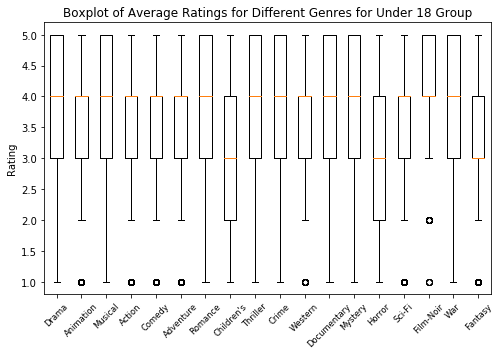

In [16]:
#Only focus on 18- population, filtering.
age_1 = main[main['Age'] == 1]

melted = pd.melt(age_1, id_vars=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode', 'MovieID', 'Rating', 'Timestamp'],
                    value_vars=['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6'],
                    var_name='GenreType', value_name='Genre')#reference to https://www.geeksforgeeks.org/python-pandas-melt/
melted = melted.dropna(subset=['Genre'])
unique_genres = melted['Genre'].unique()
data_1 = [melted[melted['Genre'] == genre]['Rating'] for genre in unique_genres]
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(data_1)
ax.set_ylabel('Rating')
ax.set_xticklabels(unique_genres, rotation=45, fontsize='small')

ax.set_title('Boxplot of Average Ratings for Different Genres for Under 18 Group')
plt.show()


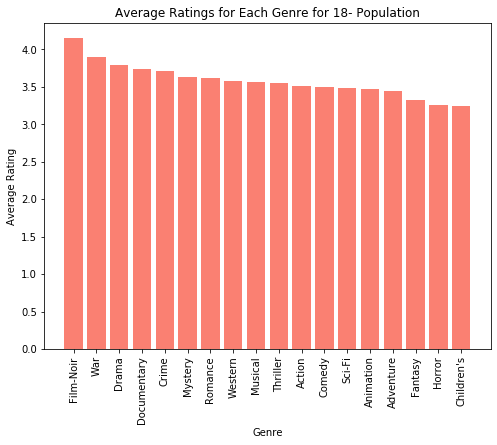

In [17]:
genre_avg_ratings = melted.groupby('Genre')['Rating'].mean().reset_index()
genre_avg_ratings = genre_avg_ratings.sort_values('Rating', ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(genre_avg_ratings['Genre'], genre_avg_ratings['Rating'], color='salmon')
ax.set_xlabel('Genre')
ax.set_ylabel('Average Rating')
ax.set_title('Average Ratings for Each Genre for 18- Population')
ax.set_xticks(range(len(genre_avg_ratings['Genre'])))
ax.set_xticklabels(genre_avg_ratings['Genre'], rotation=90)

plt.show()

## 8.2 Age 18-24 Populaion

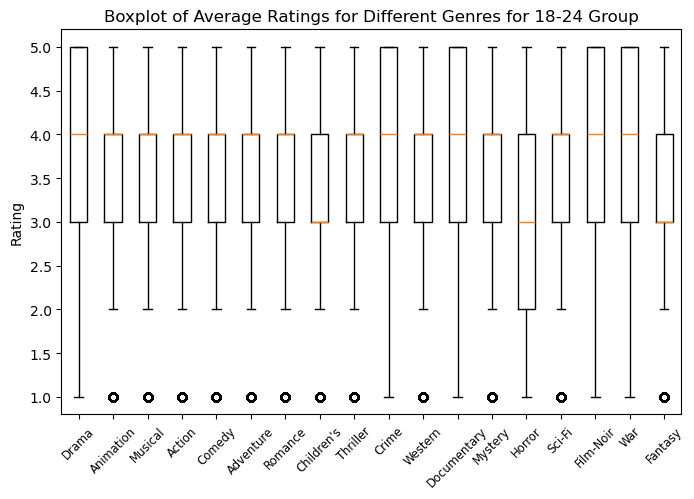

In [ ]:
age_18 = main[main['Age'] == 18]

melted_18 = pd.melt(age_18, id_vars=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode', 'MovieID', 'Rating', 'Timestamp'],
                    value_vars=['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6'],
                    var_name='GenreType', value_name='Genre')
melted_18 = melted_18.dropna(subset=['Genre'])
unique_genres = melted_18['Genre'].unique()
data_18 = [melted_18[melted_18['Genre'] == genre]['Rating'] for genre in unique_genres]
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(data_18)
ax.set_ylabel('Rating')
ax.set_xticklabels(unique_genres, rotation=45, fontsize='small')

ax.set_title('Boxplot of Average Ratings for Different Genres for 18-24 Group')
plt.show()


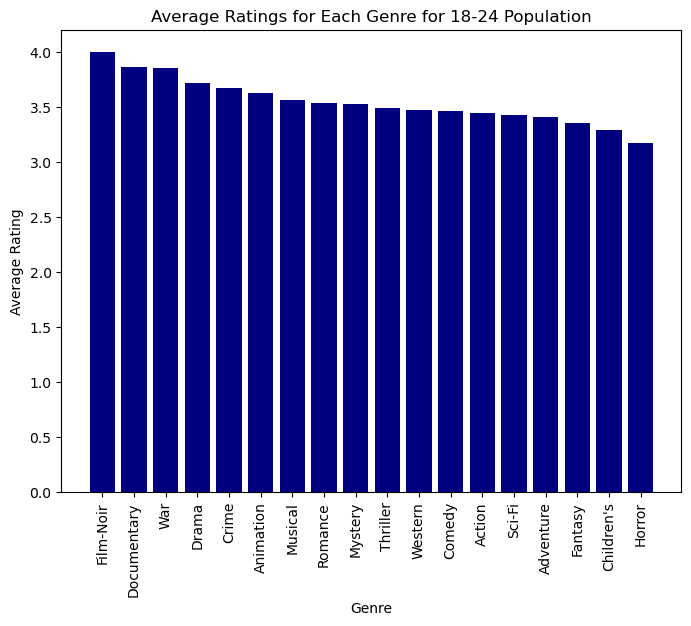

In [ ]:
genre_avg_ratings_18 = melted_18.groupby('Genre')['Rating'].mean().reset_index()
genre_avg_ratings_18 = genre_avg_ratings_18.sort_values('Rating', ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(genre_avg_ratings_18['Genre'], genre_avg_ratings_18['Rating'], color='navy')
ax.set_xlabel('Genre')
ax.set_ylabel('Average Rating')
ax.set_title('Average Ratings for Each Genre for 18-24 Population')
ax.set_xticks(range(len(genre_avg_ratings_18['Genre'])))
ax.set_xticklabels(genre_avg_ratings_18['Genre'], rotation=90)

plt.show()

## 8.3 Age 25-34 Populaion

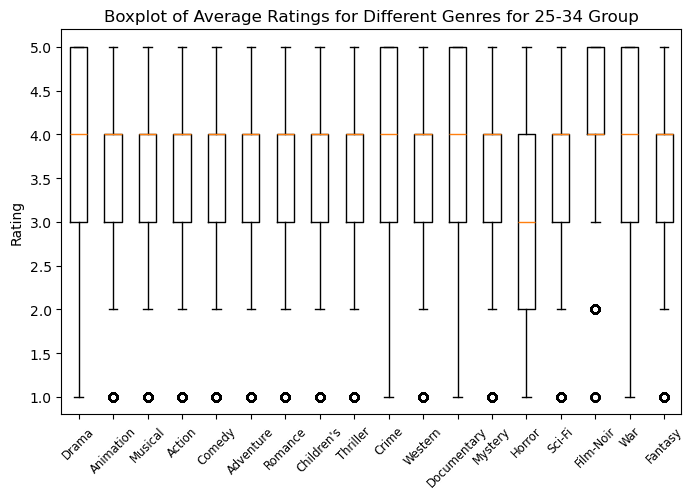

In [ ]:
age_25 = main[main['Age'] == 25]
melted_25 = pd.melt(age_25, id_vars=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode', 'MovieID', 'Rating', 'Timestamp'],
                    value_vars=['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6'],
                    var_name='GenreType', value_name='Genre')
melted_25 = melted_25.dropna(subset=['Genre'])
unique_genres = melted_25['Genre'].unique()
data_25 = [melted_25[melted_25['Genre'] == genre]['Rating'] for genre in unique_genres]
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(data_25)
ax.set_ylabel('Rating')
ax.set_xticklabels(unique_genres, rotation=45, fontsize='small')

ax.set_title('Boxplot of Average Ratings for Different Genres for 25-34 Group')
plt.show()

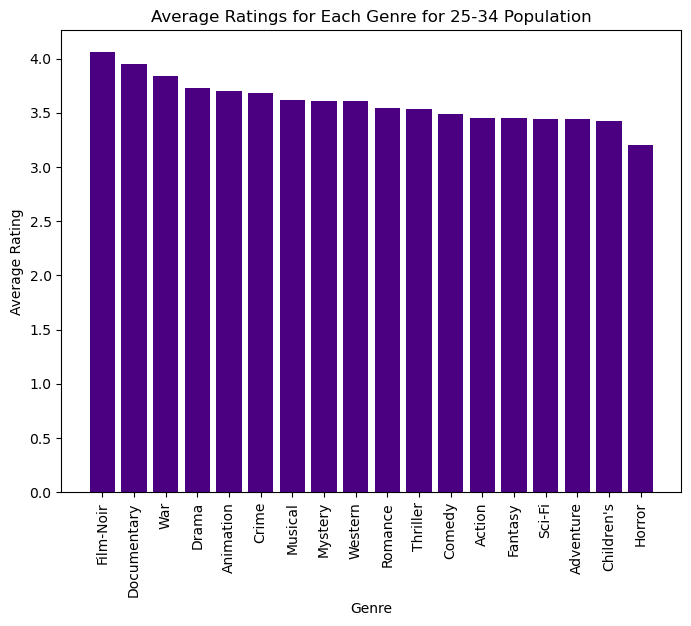

In [ ]:
genre_avg_ratings_25 = melted_25.groupby('Genre')['Rating'].mean().reset_index()
genre_avg_ratings_25 = genre_avg_ratings_25.sort_values('Rating', ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(genre_avg_ratings_25['Genre'], genre_avg_ratings_25['Rating'], color='indigo')
ax.set_xlabel('Genre')
ax.set_ylabel('Average Rating')
ax.set_title('Average Ratings for Each Genre for 25-34 Population')
ax.set_xticks(range(len(genre_avg_ratings_25['Genre'])))
ax.set_xticklabels(genre_avg_ratings_25['Genre'], rotation=90)

plt.show()

## 8.4 Age 35-44 Population

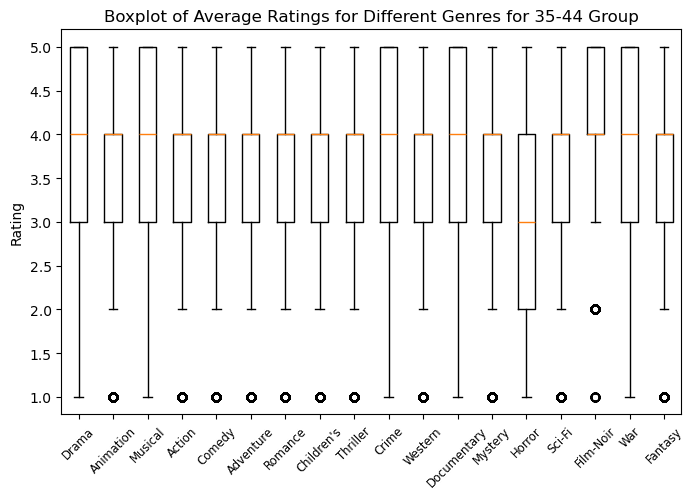

In [ ]:
age_35 = main[main['Age'] == 35]
melted_35 = pd.melt(age_35, id_vars=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode', 'MovieID', 'Rating', 'Timestamp'],
                    value_vars=['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6'],
                    var_name='GenreType', value_name='Genre')
melted_35 = melted_35.dropna(subset=['Genre'])
unique_genres = melted_35['Genre'].unique()
data_35 = [melted_35[melted_35['Genre'] == genre]['Rating'] for genre in unique_genres]
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(data_35)
ax.set_ylabel('Rating')
ax.set_xticklabels(unique_genres, rotation=45, fontsize='small')

ax.set_title('Boxplot of Average Ratings for Different Genres for 35-44 Group')
plt.show()

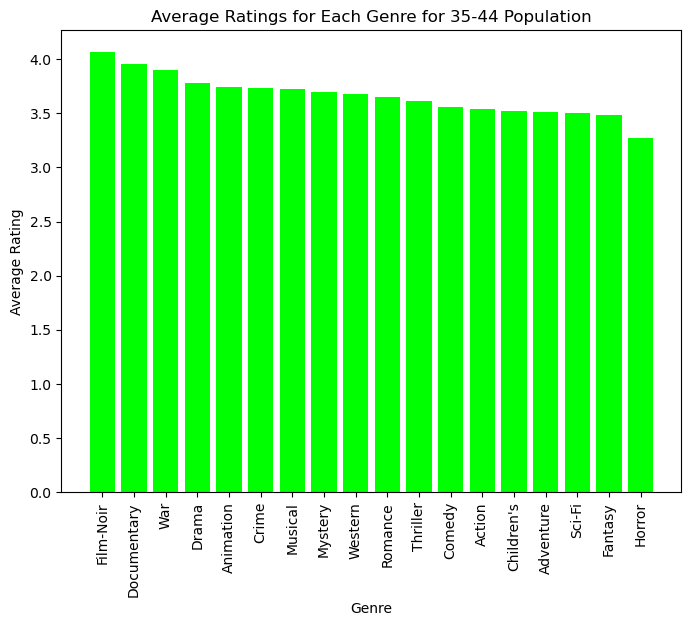

In [ ]:
genre_avg_ratings_35 = melted_35.groupby('Genre')['Rating'].mean().reset_index()
genre_avg_ratings_35 = genre_avg_ratings_35.sort_values('Rating', ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(genre_avg_ratings_35['Genre'], genre_avg_ratings_35['Rating'], color='lime')
ax.set_xlabel('Genre')
ax.set_ylabel('Average Rating')
ax.set_title('Average Ratings for Each Genre for 35-44 Population')
ax.set_xticks(range(len(genre_avg_ratings_35['Genre'])))
ax.set_xticklabels(genre_avg_ratings_35['Genre'], rotation=90)

plt.show()

## 8.5 Age 45-49 Population

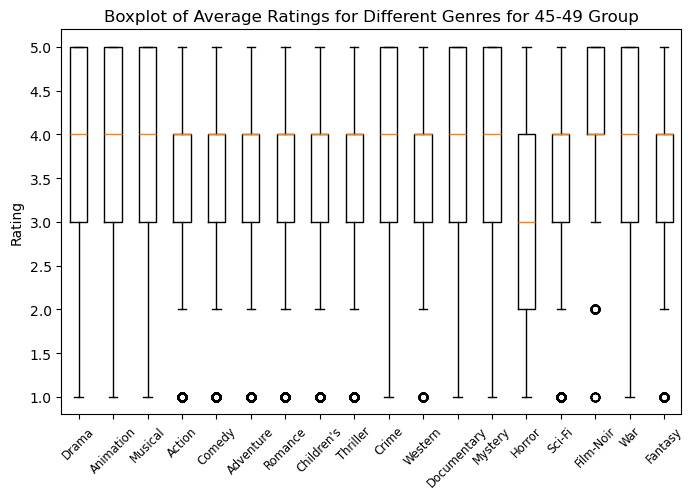

In [ ]:
age_45 = main[main['Age'] == 45]

melted_45 = pd.melt(age_45, id_vars=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode', 'MovieID', 'Rating', 'Timestamp'],
                    value_vars=['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6'],
                    var_name='GenreType', value_name='Genre')
melted_45 = melted_45.dropna(subset=['Genre'])
unique_genres = melted_45['Genre'].unique()
data_45 = [melted_45[melted_45['Genre'] == genre]['Rating'] for genre in unique_genres]
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(data_45)
ax.set_ylabel('Rating')
ax.set_xticklabels(unique_genres, rotation=45, fontsize='small')

ax.set_title('Boxplot of Average Ratings for Different Genres for 45-49 Group')
plt.show()

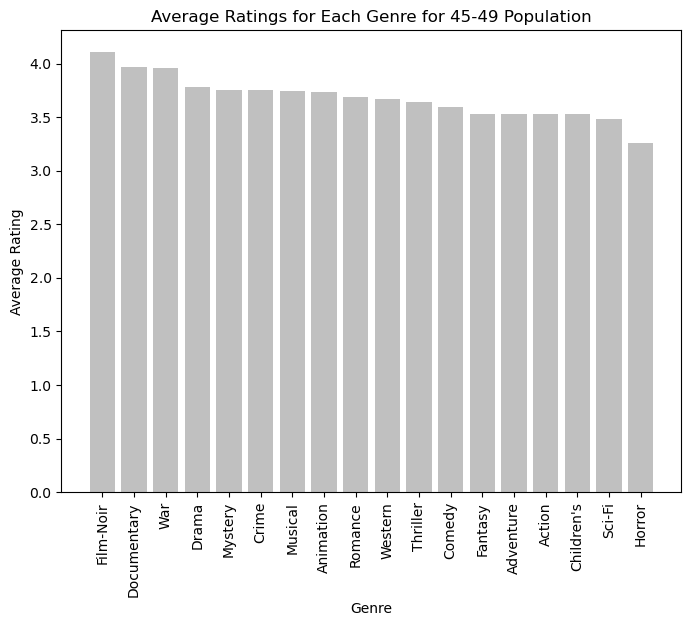

In [ ]:
genre_avg_ratings_45 = melted_45.groupby('Genre')['Rating'].mean().reset_index()
genre_avg_ratings_45 = genre_avg_ratings_45.sort_values('Rating', ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(genre_avg_ratings_45['Genre'], genre_avg_ratings_45['Rating'], color='silver')
ax.set_xlabel('Genre')
ax.set_ylabel('Average Rating')
ax.set_title('Average Ratings for Each Genre for 45-49 Population')
ax.set_xticks(range(len(genre_avg_ratings_45['Genre'])))
ax.set_xticklabels(genre_avg_ratings_45['Genre'], rotation=90)

plt.show()

## 8.6 Age 50-55 Population

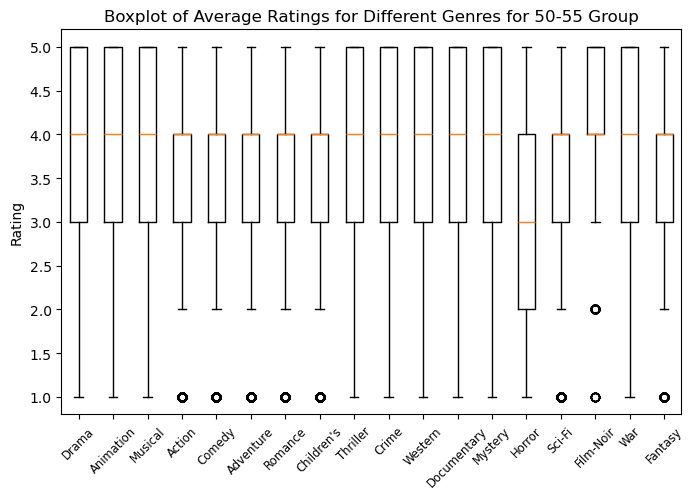

In [ ]:
age_50 = main[main['Age'] == 50]

melted_50 = pd.melt(age_50, id_vars=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode', 'MovieID', 'Rating', 'Timestamp'],
                    value_vars=['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6'],
                    var_name='GenreType', value_name='Genre')
melted_50 = melted_50.dropna(subset=['Genre'])
unique_genres = melted_50['Genre'].unique()
data_50 = [melted_50[melted_50['Genre'] == genre]['Rating'] for genre in unique_genres]
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(data_50)
ax.set_ylabel('Rating')
ax.set_xticklabels(unique_genres, rotation=45, fontsize='small')

ax.set_title('Boxplot of Average Ratings for Different Genres for 50-55 Group')
plt.show()

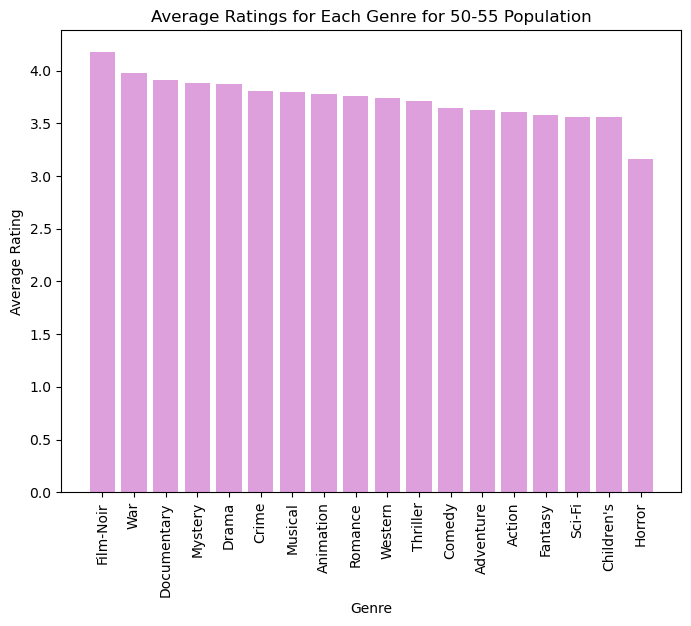

In [ ]:
genre_avg_ratings_50 = melted_50.groupby('Genre')['Rating'].mean().reset_index()
genre_avg_ratings_50 = genre_avg_ratings_50.sort_values('Rating', ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(genre_avg_ratings_50['Genre'], genre_avg_ratings_50['Rating'], color='plum')
ax.set_xlabel('Genre')
ax.set_ylabel('Average Rating')
ax.set_title('Average Ratings for Each Genre for 50-55 Population')
ax.set_xticks(range(len(genre_avg_ratings_50['Genre'])))
ax.set_xticklabels(genre_avg_ratings_50['Genre'], rotation=90)

plt.show()

## 8.7 Age 56+ Population

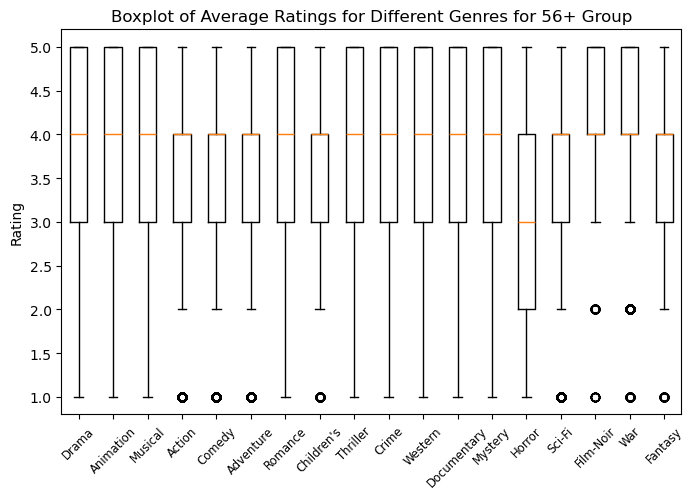

In [ ]:
age_56 = main[main['Age'] == 56]

melted_56 = pd.melt(age_56, id_vars=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode', 'MovieID', 'Rating', 'Timestamp'],
                    value_vars=['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6'],
                    var_name='GenreType', value_name='Genre')
melted_56 = melted_56.dropna(subset=['Genre'])
unique_genres = melted_56['Genre'].unique()
data_56 = [melted_56[melted_56['Genre'] == genre]['Rating'] for genre in unique_genres]
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(data_56)
ax.set_ylabel('Rating')
ax.set_xticklabels(unique_genres, rotation=45, fontsize='small')

ax.set_title('Boxplot of Average Ratings for Different Genres for 56+ Group')
plt.show()

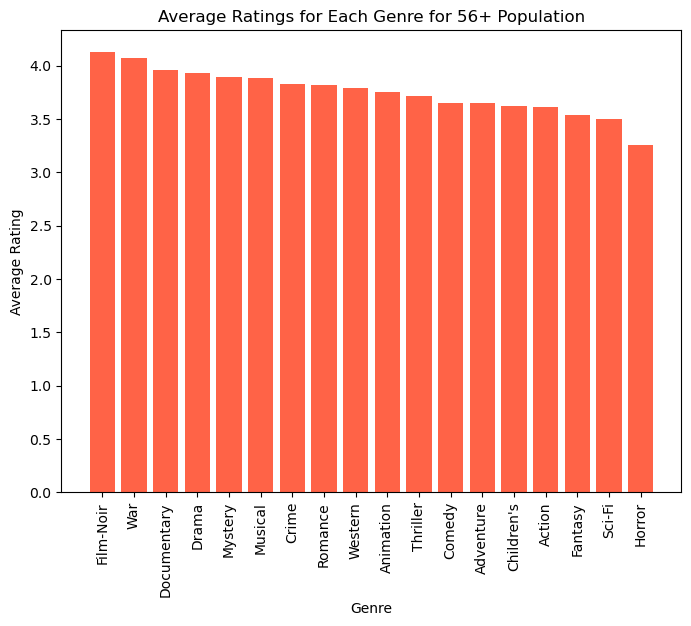

In [ ]:
genre_avg_ratings_56 = melted_56.groupby('Genre')['Rating'].mean().reset_index()
genre_avg_ratings_56 = genre_avg_ratings_56.sort_values('Rating', ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(genre_avg_ratings_56['Genre'], genre_avg_ratings_56['Rating'], color='tomato')
ax.set_xlabel('Genre')
ax.set_ylabel('Average Rating')
ax.set_title('Average Ratings for Each Genre for 56+ Population')
ax.set_xticks(range(len(genre_avg_ratings_56['Genre'])))
ax.set_xticklabels(genre_avg_ratings_56['Genre'], rotation=90)

plt.show()

## 8.8 Conclusion

From above, it is very clear that Film-Noir have the highest rating for general population, with exclusion to 18-24 population which have a wider scoring from 3 to 5. All other age groups have 50% people rating Film-Noir from 4 to 5. Also across all ages, Film-Noir has the highest average rating. It represents that Film-Noir has a high popularity amongst the entire population.

Also, it is clear that more than half of the population across all different age groups would have the lowest rating for horror movies(from 2 to 4). And Horror genre also has the lowest average rating.

From those box plots above, we can easily see that the elder and younger population seem to have a high acceptability for various movie genres. Since they are more likely to rate movies from different genres with a relatively higher score, from 4 to 5. Additionally, except Firm-Noir, some other movie genres, including Drama, War, Crime and Documentary, are also popular among a wide range of age groups.

# 9.Occupation Preference

**Relationship between average ratings of different films and occupation**

To find this relationship, we consider a heat map between different types of films and user occupations, where each cell corresponds to the average rating of a specific occupation for a specific type of film. From our original data, some films may have more than one genre. So we first split the data again with "|", and then create a new row for each genre of a film. Secondly, because occupations are represented by different numbers in our data, we read through the Readme file to check what occupations each number represents and relate them. After doing this we can create the pivot table and then draw the heat map.

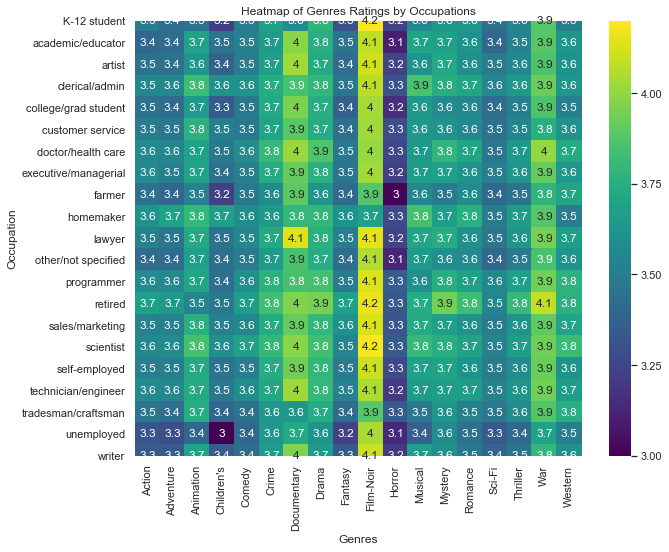

In [ ]:
#Read and Give Headers (Convenient for selecting particular column in the future analysis)
movies_df = pd.read_csv('movies2.csv', header=None, names=['MovieID', 'MovieName', 'Title', 'Genres'], encoding='latin1')
ratings_df = pd.read_csv('ratings.csv', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='latin1')
users_df = pd.read_csv('users.csv', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode'], encoding='latin1')

#Merge the data
merged_df = pd.merge(pd.merge(ratings_df, movies_df, on='MovieID'), users_df, on='UserID')

#Split the line for movies which have more than one Genres
merged_df['Genres'] = merged_df['Genres'].str.split('|')
merged_df = merged_df.explode('Genres')

#Map the number and the Occupation
##Little help with GPT and mainly know by the reference on https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.map.html#pandas.DataFrame.map
occupation_mapping = {
    0: "other/not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",4: "college/grad student", 5: "customer service", 6: "doctor/health care",
    7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student",11: "lawyer", 12: "programmer", 13: "retired", 14: "sales/marketing",15: "scientist",
    16: "self-employed", 17: "technician/engineer",18: "tradesman/craftsman", 19: "unemployed", 20: "writer"
}

merged_df['Occupation'] = merged_df['Occupation'].map(occupation_mapping)

#Create the pivot table
pivot_table_heatmap = merged_df.pivot_table(index='Occupation', columns='Genres', values='Rating', aggfunc='mean')

#Plot
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table_heatmap, annot=True, cmap='viridis', vmin=3, vmax=4.2)

plt.title('Heatmap of Genres Ratings by Occupations')
plt.show()

From the plot we can see darker colours represent lower scores, and lighter colours correspond to higher scores. It is clear that Film-Noir, War, Documentary have higher average scores for almost all the occupations. While horror films is the opposit: it is not popular for almost all the occupations.

# 10. Regional difference

## For Part 10, we kindly ask you to run the codes below, then the map will appear in front of you like a real magic ; )


<span style="color:red">Although we tried so hard on that but it still doesn't show automatically, please run the code to see the actual map we created, I will also attached screenshot of the map below, many thanks! (Also, a seperate ipynb file of the following codes is pushed alongside)<span style="color:red">


These 3 datasets provide a wide range of information, the objective of this study is to analyse how movie ratings are distributed for various genres. Specifically, we attempt to identify the different audience groups for various movie genres, as well as the differences among those audiences. For example: Do male users prefer dramas more than female users? Do children and teenagers favour comedy more?

According to the website:https://www.structnet.com/instructions/zip_min_max_by_state.html which have provided the range of zip-code for every state in the US. We can use this information to find out the specific state for every users, and further plot the most popular movie genre, and also the highest rated movie genre in every state of the US(Mainland USA, Hawaii and Alaska).

Note that some of the zip code are "Unavailable" which means they are out of the USA mainland, Alaska and Hawaii, which can not be plotted by using the Plotly on the United State. For example, the zip code ’96931’ is in Guam, ‘96661’ is an Armed Forces in Pacific, and there are 3 users living in the Commonwealth of Puerto Rico, etc.. These are not considered in our map plot.

Additionally, there are zip-codes can not be found in map which might be typos. We simply treat them as error and discard them.

In [ ]:
file_88 = 'movies.csv'
movies = pd.read_csv(file_88)
file_2 = 'users.csv'
users = pd.read_csv(file_2)
file_3 = 'ratings.csv'
ratings = pd.read_csv(file_3)

# Fetch the Zip Code Data
url = 'https://www.structnet.com/instructions/zip_min_max_by_state.html'
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html5lib')
    table = soup.find('table')
    rows = table.find_all('tr')
    data = []

    for row in rows:
        cols = [ele.text.strip() for ele in row.find_all('td')]
        data.append(cols)

    df = pd.DataFrame(data, columns=['ID', 'State Name', 'ST', 'Zip Min', 'Zip Max'])

    df.dropna(inplace=True)
    df.to_csv('zip_codes.csv', index=False)

# Construct a zip_codes.csv file successfully
zip_codes = pd.read_csv('zip_codes.csv')
users_19 = pd.read_csv(file_2, header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode'])

users_19['ZipCode'] = pd.to_numeric(users_19['ZipCode'], errors='coerce')
users_19 = users_19.dropna(subset=['ZipCode'])
users_19['ZipCode'] = users_19['ZipCode'].astype(int)

# Find the state corresponding to every zip_code
def find_state(zip_code):
    for index, row in zip_codes.iterrows():
        if row['Zip Min'] <= zip_code <= row['Zip Max']:
            return row['ST']
    return None

users_19['State'] = users_19['ZipCode'].apply(find_state)

Note that we have droped some NaN zip codes since they might be incomplete, wrong, or not in USA mainland, Hawaii and Alaska.

In [ ]:
movies_tomerge_19 = pd.read_csv('movies.csv', names=['MovieID', 'Title', 'Year', 'Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6'], header=None)
ratings_tomerge_19 = pd.read_csv('ratings.csv', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], header=None)

user_ratings_19 = pd.merge(users_19, ratings_tomerge_19)
merged_data_19 = pd.merge(user_ratings_19, movies_tomerge_19)

Here we construct a new dataframe of the most favoured movie genres of each state as well as the code(abbr) for each state to further use plotly for a United State map

In [ ]:
# Initialize the data frame for the top favourite movie genre of each state as well as informations
all_genres_19 = pd.DataFrame()
genre_columns_19 = ['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6']
all_genres_19 = pd.DataFrame()
for genre_col_19 in genre_columns_19:
    temp_19 = merged_data_19[['State', genre_col_19, 'Rating']].rename(columns={genre_col_19: 'Genre'})
    all_genres_19 = pd.concat([all_genres_19, temp_19])

# Drop NA
all_genres_19 = all_genres_19.dropna(subset=['Genre'])

genre_ratings_19 = all_genres_19.groupby(['State', 'Genre'])['Rating'].mean().reset_index()

# Identify the top rated genre
top_genres_19 = genre_ratings_19.loc[genre_ratings_19.groupby('State')['Rating'].idxmax()]

# Construct both abbreviations and full name of each state
abbr_to_name = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut','DC': 'District Of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire',
    'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina',
    'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania',
    'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee',
    'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

top_genres_19['State'] = top_genres_19['State'].map(abbr_to_name)
name_to_abbr = {v: k for k, v in abbr_to_name.items()}
top_genres_19['Statecode'] = top_genres_19['State'].map(name_to_abbr)
top_genres_19.head()


,State,Genre,Rating,Statecode
6,Alaska,Documentary,5.000000,AK
24,Alabama,Documentary,4.275862,AL
45,Arkansas,Film-Noir,3.824742,AR
63,Arizona,Film-Noir,4.107296,AZ
81,California,Film-Noir,4.098964,CA


In [ ]:
# Align each genre to a specific colour
genre_color_map = {
    'Documentary': 'goldenrod',
    'Film-Noir': 'skyblue',
    'War': 'olive',
    'Fantasy': 'violet',
    'Animation': 'wheat',
    'Western': 'pink'
}

# Plotly to plot a choropleth for the map of the USA, with the information of top rated movies
fig = px.choropleth(top_genres_19,
                    locations='Statecode',
                    color='Genre',
                    color_discrete_map=genre_color_map,
                    locationmode='USA-states',
                    hover_name='State',
                    hover_data=['Rating'],
                    title='Top Movie Genres by State',
                    scope='usa',
                   )

# Reference to https://plotly.com/python/reference/layout/geo/
fig.update_geos(showland=True, landcolor="White",
                showlakes=True, lakecolor="White",
                showsubunits=True, subunitcolor="Grey")

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# Magic
fig.show(reminder = 'notebook')
fig.write_html('fig1.html', auto_open=True)

In [ ]:
all_genres_20 = pd.DataFrame()
genre_columns = ['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6']
for genre_col in genre_columns:
    temp = merged_data_19[['State', genre_col, 'Rating']].rename(columns={genre_col: 'Genre'})
    all_genres_20 = pd.concat([all_genres_20, temp])


# Drop NA, data cleaning
all_genres_20.dropna(subset=['Genre'], inplace=True)
genre_counts = all_genres_20.groupby(['State', 'Genre']).size().reset_index(name='Count')

# Find the most counted genre for each state
most_count = genre_counts.sort_values('Count', ascending=False).drop_duplicates(['State'])

# Keep the abbreviation and full name inside dataframe
abbr_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'DC': 'District of Columbia',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois',
    'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana',
    'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota',
    'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon',
    'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia',
    'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

name_to_abbr = {v: k for k, v in abbr_to_name.items()}
most_count['Statecode'] = most_count['State']
most_count['State'] = most_count['State'].map(abbr_to_name)
most_count.head()

,State,Genre,Count,Statecode
79,California,Drama,66003,CA
618,New York,Drama,27762,NY
418,Minnesota,Comedy,23893,MN
256,Illinois,Comedy,18631,IL
777,Texas,Comedy,18546,TX


In [ ]:
# Specify A color for each genre
genre_color_map = {
    'Drama': 'chocolate',
    'Action': 'springgreen',
    'Comedy': 'FireBrick',
}

# use plotly to plot choropleth for usa's map and info about most counted genre
fig = px.choropleth(
    most_count,
    locations='Statecode',
    color='Genre',
    color_discrete_map=genre_color_map,
    locationmode='USA-states',
    hover_name='State',
    hover_data=['Count'],
    title='Most watched Movie Genres by State',
    scope='usa',
)

# Show the map of usa more accurate and clear
fig.update_geos(
    showland=True,
    landcolor="White",
    showlakes=True,
    lakecolor="White",
    showsubunits=True,
    subunitcolor="Grey"
)

fig.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0}
)
# Magic
fig.show(reminder = 'notebook')
fig.write_html('fig2.html', auto_open=True)

From above, it's clear that Note that 'Firm-Noir'&'documentary' are top 2 favourite in general. Note that the "top favourite genre by each state" might not be accurate, for example, if only 2 people have watched a documentary movie in a small state and they both rated the documentary movie quite high, then the result would be biased. Thus, we can also plot the 'Top genre that people watches the most in each state' on a US map.

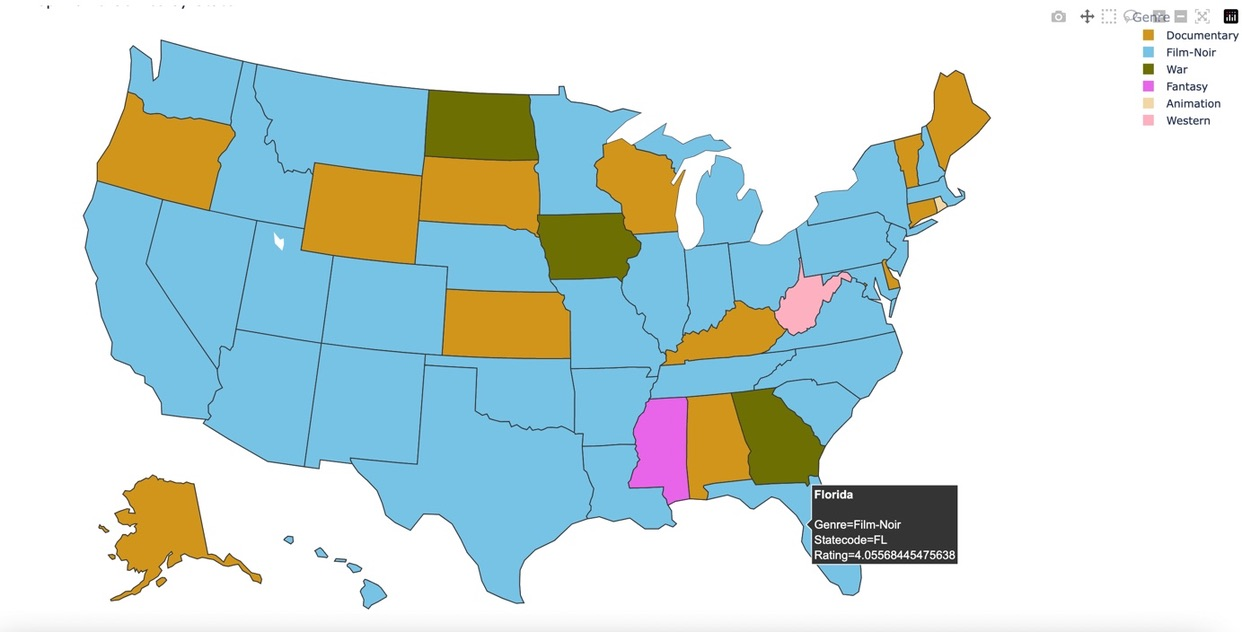

In [20]:
display(Image(filename="ratingmap.jpg"))

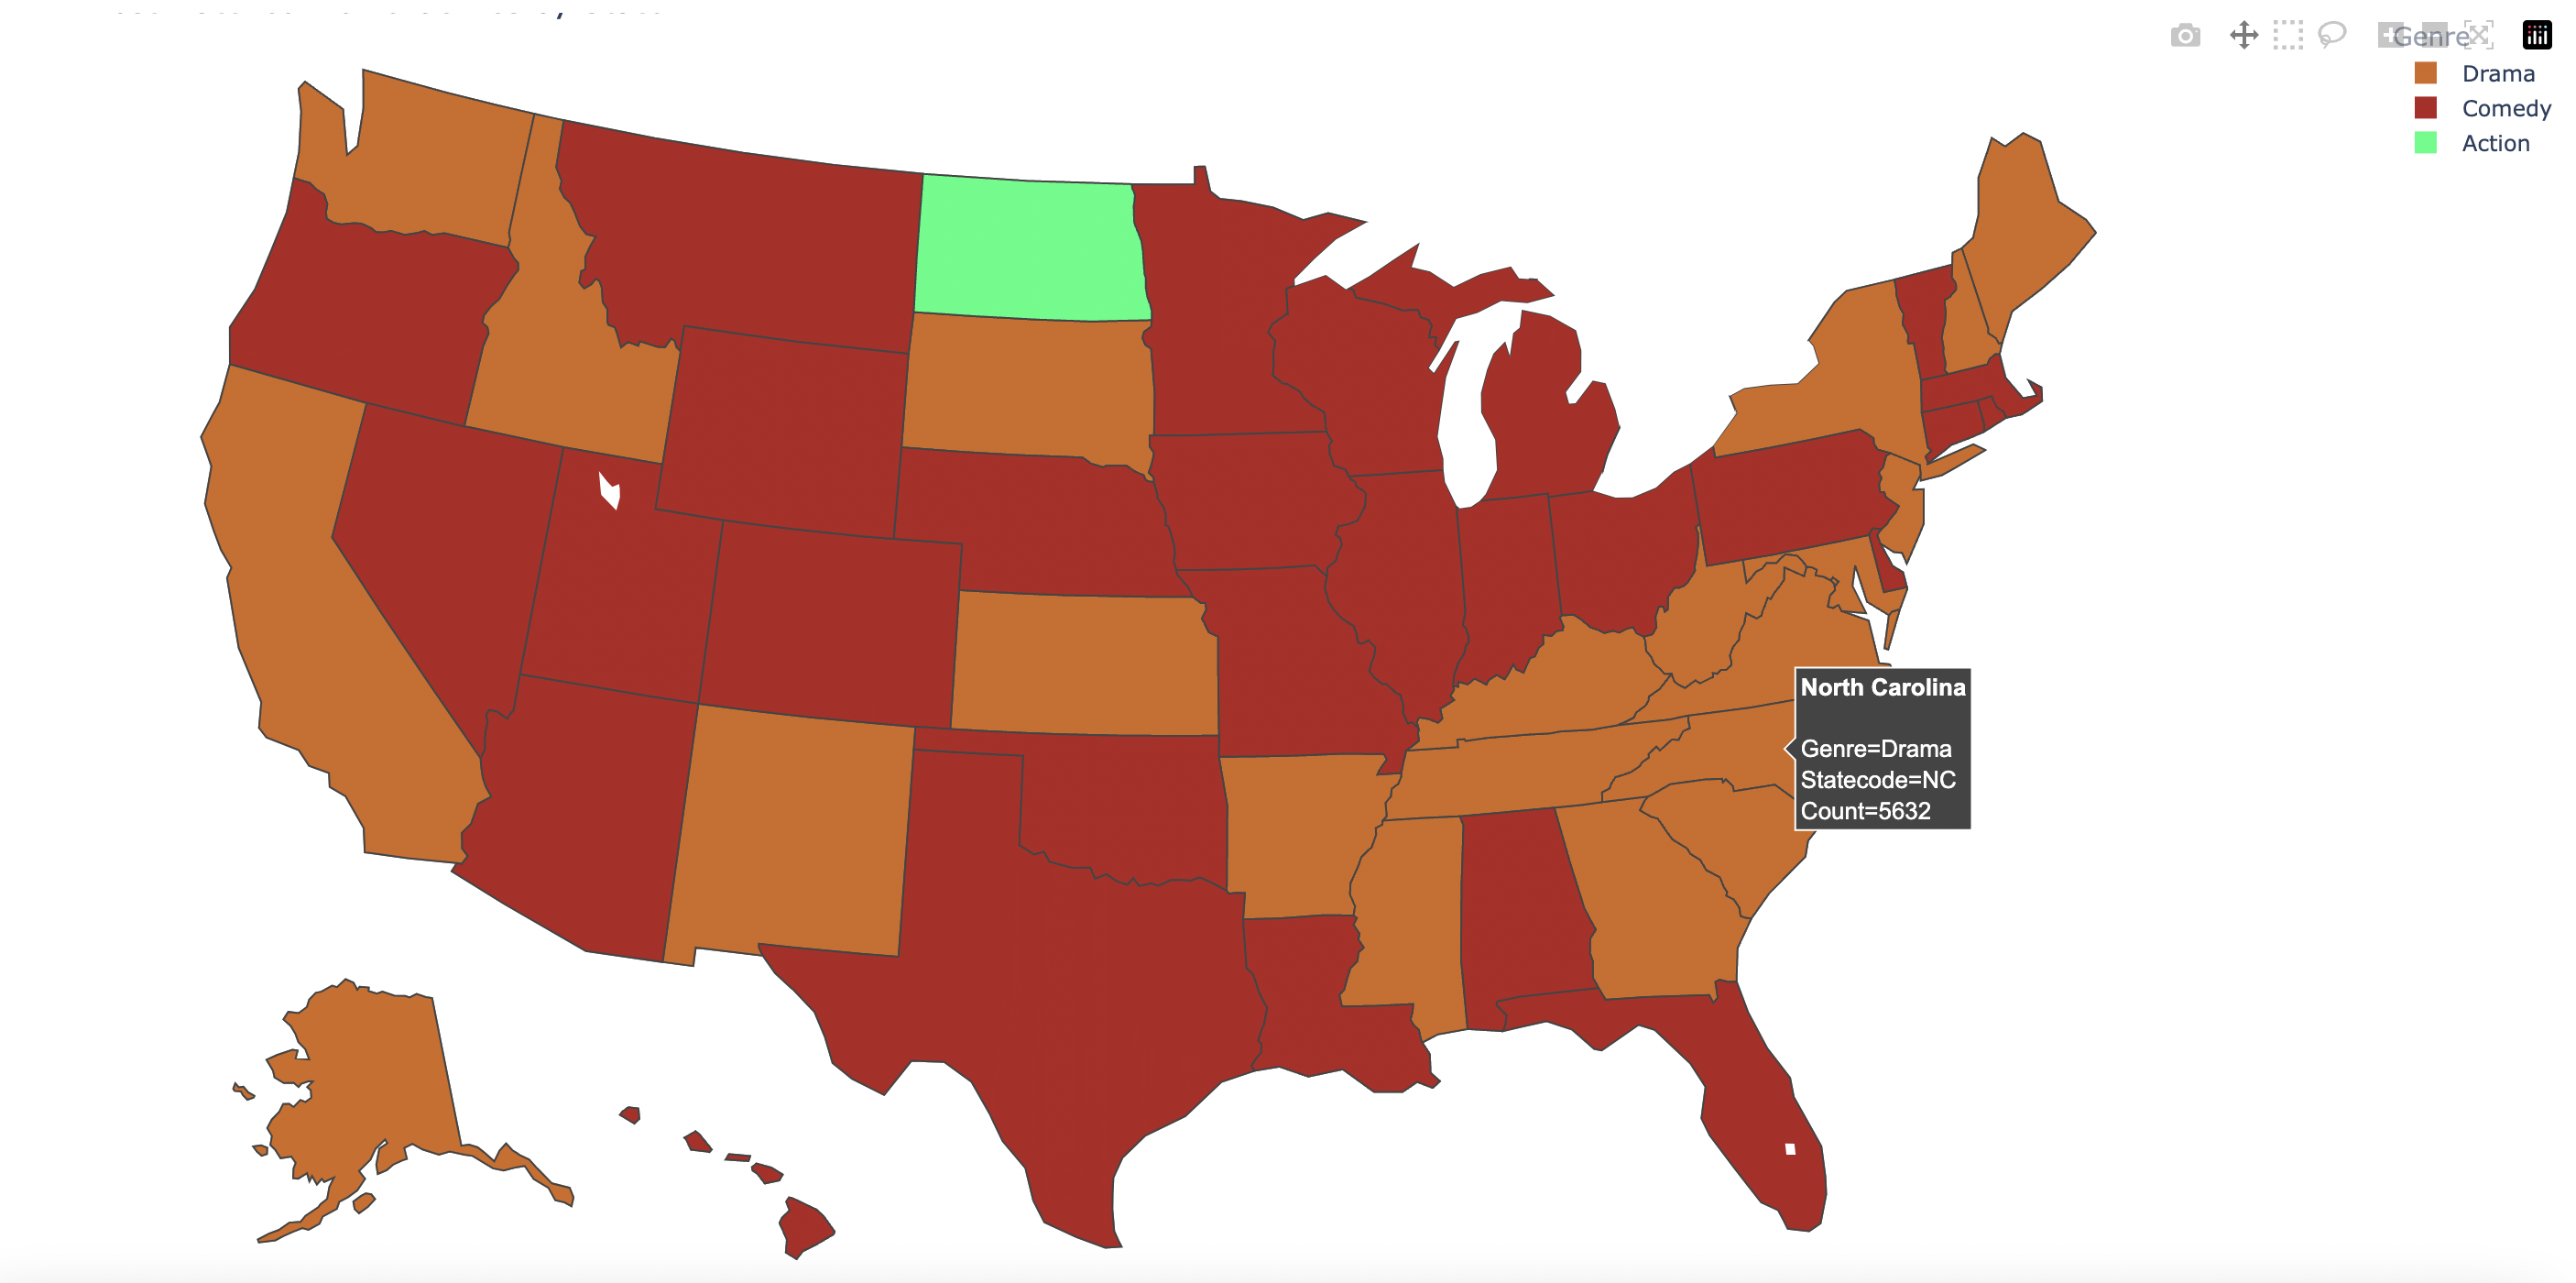

In [21]:
display(Image(filename="countmap.jpg"))

# 11.Data Modelling

## Predicting how high or low a film's rating will go

### Use users' information to make the prediction

Firstly, we try to use the users' age, gender and occupation to predict whether their scores for the movie are high or low. So by integrating the data, we select age, gender and occupation as the x-axis of the training set. And whether the movie scores are high or low as the y-axis (assume movie ratings greater or equal to 3 as high, and ratings lower than 3 as low) of the training set to draw the ROC plot. The code is shown as below:

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Accuracy,TPR,FPR
Logistic Regression,0.836,1.000,1.000
Nearest Neighbour,0.813,0.963,0.956
Random Forest,0.836,1.000,1.000
AdaBoost,0.836,1.000,1.000


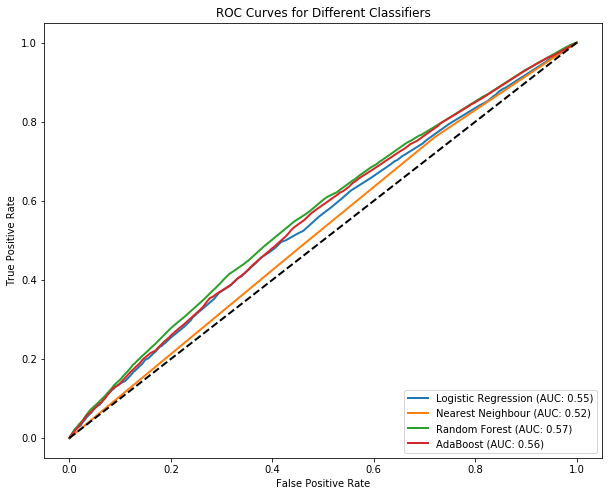

In [20]:
####code for creating ROC plot for using users' information to predict whether movie ratings will be high(>=3) or not
matplotlib.rcParams["figure.figsize"] = (10, 8)

#Notify the using Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=0, max_iter=1000),
    "Nearest Neighbour": KNeighborsClassifier(5),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=0),
    "AdaBoost": AdaBoostClassifier(random_state=0),
}

#Give header to the csv file for future analysis
movies_df = pd.read_csv('movies2.csv', header=None, names=['MovieID', 'MovieName', 'Title', 'Genres'], encoding='latin1')
ratings_df = pd.read_csv('ratings.csv', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='latin1')
users_df = pd.read_csv('users.csv', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode'], encoding='latin1')

#Merge the data using MovieID and UserID
merged_df = pd.merge(pd.merge(ratings_df, movies_df, on='MovieID'), users_df, on='UserID')

#Create the condition for plotting the ROC plot whether ratings will bigger or equal to 3 or not
merged_df['RatingClass'] = (merged_df['Rating'] >= 3).astype(int)

#Create the dataset and transform the type of gender into numerical variables that can be used for analysing
X = merged_df[['Age', 'Gender', 'Occupation']]
y = merged_df['RatingClass']
X = pd.get_dummies(X, columns=['Gender'])

#Create the training dataset and test dataset (80% for training 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

y_hats = {}
p_hats = {}
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_hats[name] = classifier.predict(X_test)
    p_hats[name] = classifier.predict_proba(X_test)[:, 1]

#Create the confiusion matrix
performance = {}
for name, y_pred in y_hats.items():
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    acc = accuracy_score(y_test, y_pred)
    performance[name] = [acc, tpr, fpr]

perf_df = pd.DataFrame.from_dict(
    performance, orient="index", columns=["Accuracy", "TPR", "FPR"]
)

with pd.option_context("display.float_format", "{:0.3f}".format):
    display(perf_df)

for name, p_pred in p_hats.items():
    fpr, tpr, _ = roc_curve(y_test, p_pred)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC: {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Classifiers")
plt.show()

From the output of the above code, we can see that if we want to use the user's information including age, gender and occupation to predict whether he/she is more likely to give the film a high rating or a low rating.
About the AUC value: AUC value ranges from 0 to 1, the higher the value the better the performance of the classifier. An ideal classifier will have an AUC close to 1, indicating that it has a high true class rate and a low false positive rate.
From the plot, we can see that all four classifiers have almost the same accuracy. But random forest has the best performance with the highest AUC value. However, even the best random forest has an AUC value of only 0.57, which means that although it is possible to use this model to guess the user's rating of a film, it is still almost the same as a random guest because the AUC value is still close to 0.5.

### Use movie itself (movie type) to make prediction

<span style="color:red">!!!Note: This chunk of code may take a long time(over 30 minutes) to run. So, just in case, the ROC plot is attached as a jpg file.<span style="color:red">

Next, we try to use the movie genre to predict the ratings. Because some movies contain more than one type, after integrating the data, we separate the genres according to "|" and put them into a new row (file movie2.csv mentioned at the beginning). This time, the training set of the x-axis will become the movie type, while the training set of the y-axis will still be the movie ratings.

In [ ]:
####Code for ROC plot using movie type
matplotlib.rcParams["figure.figsize"] = (10, 8)

movies_df = pd.read_csv('/content/movies2.csv', header=None, names=['MovieID', 'MovieName', 'Title', 'Genres'], encoding='latin1')
ratings_df = pd.read_csv('/content/ratings.csv', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='latin1')
users_df = pd.read_csv('/content/users.csv', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode'], encoding='latin1')

merged_df = pd.merge(pd.merge(ratings_df, movies_df, on='MovieID'), users_df, on='UserID')

merged_df['Genres'] = merged_df['Genres'].str.split('|')
merged_df = merged_df.explode('Genres')

genres_mapping = {
    "Action": 1, "Adventure": 2, "Animation": 3, "Children's": 4, "Comedy": 5,
    "Crime": 6, "Documentary": 7, "Drama": 8, "Fantasy": 9, "Film-Noir": 10,
    "Horror": 11, "Musical": 12, "Mystery": 13, "Romance": 14, "Sci-Fi": 15,
    "Thriller": 16, "War": 17, "Western": 18
}

merged_df['Genres'] = merged_df['Genres'].map(genres_mapping)

X = merged_df[['Genres']]
y = (merged_df['Rating'] >= 3).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

classifiers = {
    "Logistic Regression": LogisticRegression(random_state=0, max_iter=1000),
    "Nearest Neighbour": KNeighborsClassifier(5),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=0),
    "AdaBoost": AdaBoostClassifier(random_state=0),
}

performance = {}
plt.figure(figsize=(10, 8))
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    acc = accuracy_score(y_test, y_pred)
    performance[name] = [acc, tpr, fpr]

    fpr_roc, tpr_roc, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr_roc, tpr_roc, lw=2, label=f"{name} (AUC: {auc(fpr_roc, tpr_roc):.2f})")

perf_df = pd.DataFrame.from_dict(performance, orient="index", columns=["Accuracy", "TPR", "FPR"])
with pd.option_context("display.float_format", "{:0.3f}".format):
    display(perf_df)

plt.plot([0, 1], [0, 1], linestyle="--")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Classifiers")
plt.show()

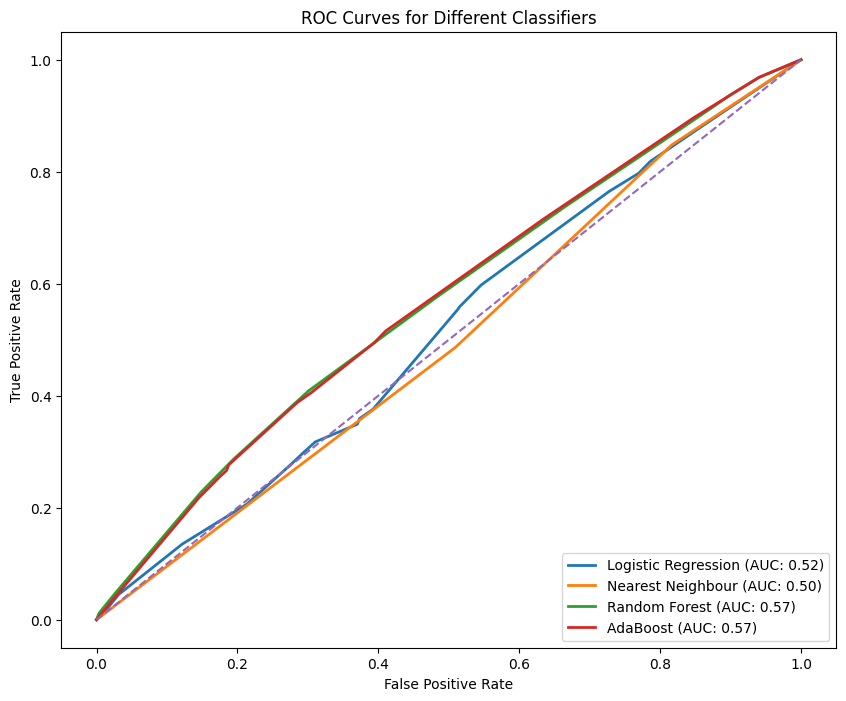

In [ ]:
display(Image(filename="ROC2.jpg"))

From the plot above, we can see that when the genre of the movie itself is used to predict the level of the movie rating. The result is almost the same as that of using users' information: random forest is still the best model.

# 12.Final conclusion

In conclusion, the random forest model is the best choice for predicting movie ratings using either users information or movie genre. The results for movie genre are almost the same between using users' information and movie genres.
If a more accurate model is needed to predict movie ratings, there are some additional factors that need to be taken into account that are not covered in this report. Which may include, firstly, the dataset may need to be expanded for more relevant data in order to obtain more features associated with movie ratings; and secondly, the quality of the data may need to be further filtered(for movie rating data, we may remove movies or movie genres with less than a certain number of ratings e.g., less than 100 ratings. And only consider movies or movie genres with a higher number of ratings); and finally, the selection of models, which may need to be more complex, such as using a deep learning model, in order to obtain more accurate results.

# Possible future research direction

**Movie recommendation system**

Based on users' characteristics such as age, gender, occupation, etc., as well as their favourite movies and their genres, deep learning is carried out to build a recommendation system, which can recommend the types of movies they may like by inputting their age, gender and other characteristics, and display the movies with relatively high ratings of that kind.